#CISC-873-DM-F22-A3: Fake Reddit Prediction


the goal is predict if a specific reddit post is fake news or not, by looking at its title

##Download data from kaggle

In [ ]:
 !pip install kaggle --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!mkdir ~/.kaggle


In [ ]:
! cp kaggle.json ~/.kaggle

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c cisc-873-dm-f22-a3

  0% 0.00/5.62M [00:00<?, ?B/s]
100% 5.62M/5.62M [00:00<00:00, 59.9MB/s]


In [ ]:
!unzip /content/cisc-873-dm-f22-a3.zip

Archive:  /content/cisc-873-dm-f22-a3.zip
  inflating: sample_submission.csv   
  inflating: x_test.csv              
  inflating: xy_train.csv            


##Data Loading 


In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [ ]:
#read train and test files
df = pd.read_csv('xy_train.csv')
df_test_K = pd.read_csv('x_test.csv')

##Exploration of training data

In [ ]:
df.shape

(60000, 3)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      60000 non-null  int64 
 1   text    60000 non-null  object
 2   label   60000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.4+ MB


In [ ]:
df.head()

,id,text,label
0,265723,A group of friends began to volunteer at a hom...,0
1,284269,British Prime Minister @Theresa_May on Nerve A...,0
2,207715,"In 1961, Goodyear released a kit that allows P...",0
3,551106,"Happy Birthday, Bob Barker! The Price Is Right...",0
4,8584,"Obama to Nation: 聙""Innocent Cops and Unarmed Y...",0


In [ ]:
#Check the data for missing values in training data
df.isnull().sum()

id       0
text     0
label    0
dtype: int64

data has not missing values

In [ ]:
#Check the data for duplicates 
df.duplicated().any()

False

data has not duplicated rows

In [ ]:
#describe the text column
df['text'].describe()

count                                                 60000
unique                                                59645
top       /r/Fakehistoryporn subscribers as they attempt...
freq                                                     14
Name: text, dtype: object

text has 59645 unique values out of 60000 rows so it has a duplicated values so drop these rows in preprocessing step

In [ ]:
df.shape

(60000, 3)

In [ ]:
#check the target column 
df['label'].value_counts()

0    32172
1    27596
2      232
Name: label, dtype: int64

"label" should be 0 or 1 so drop any row when "label"=2 in preprocessing step

In [ ]:
# Distribution of label
df["label"].value_counts(normalize=True)

0    0.536200
1    0.459933
2    0.003867
Name: label, dtype: float64

In [ ]:
df.shape

(60000, 3)

###summary 

training data has not missing valuse 

"label" column has (0 , 1 , 2 ) values,but it should be (0 or 1)only

"text" column has a duplicated values


##imp

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report,confusion_matrix,roc_curve
from sklearn.metrics import precision_score,recall_score,f1_score,accuracy_score
from sklearn.metrics import precision_recall_curve
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(y_test, y_pred):
  #Get the confusion matrix
  cf_matrix = confusion_matrix(y_test, y_pred,labels=[0,1])
 
  #print(cf_matrix)
     
  group_counts = ["{0:0.0f}".format(value) for value in
      cf_matrix.flatten()]

  group_percentages = ["{0:.2%}".format(value) for value in
            cf_matrix.flatten()/np.sum(cf_matrix)]

  labels = [f"{v1}\n{v2}\n" for v1, v2 in
  zip(group_counts,group_percentages)]

  labels = np.asarray(labels).reshape(2,2)

  ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

  ax.set_title('  Confusion Matrix  \n\n');
  ax.set_xlabel('\nPredicted labels')
  ax.set_ylabel('Actual labels ');

  ## Ticket labels - List must be in alphabetical order
  ax.xaxis.set_ticklabels([0,1])
  ax.yaxis.set_ticklabels([0,1])

  ## Display the visualization of the Confusion Matrix.
  plt.show()

In [ ]:
#visualization for roc_curve
from sklearn.metrics import roc_curve , roc_auc_score
def plot_roc_curve(y_test, y_pred):
  #calculate and virtualize the roc curve for the test set
  fpr, tpr, thresholds = roc_curve(y_test, y_pred)
  roc_auc = roc_auc_score(y_test, y_pred)
  plt.plot(fpr, tpr, 'r', label = 'AUC = %0.4f' % roc_auc)
  plt.plot(fpr, tpr, color='red', label='')
  plt.plot([0, 1], [0, 1], color='blue', linestyle='--')
  plt.xlabel('FPR')
  plt.ylabel('TPR')
  plt.legend(loc = 'lower right')
  plt.grid()

##First Solution

the first solution is applaying preprocessing that(check missing values and any dublicate and remove rows with dupliacte valus and check distribution of the target column and remove any rows with not proper label (remove any rows with label=2)and check quality(balance) of data ) and not applay any preprocessing for "text" column

###Data cleaning for training data 

In [ ]:
df_FS=df

In [ ]:
df_FS.shape

(60000, 3)

In [ ]:
df_FS.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      60000 non-null  int64 
 1   text    60000 non-null  object
 2   label   60000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.4+ MB


In [ ]:
df_FS.head()

,id,text,label
0,265723,A group of friends began to volunteer at a hom...,0
1,284269,British Prime Minister @Theresa_May on Nerve A...,0
2,207715,"In 1961, Goodyear released a kit that allows P...",0
3,551106,"Happy Birthday, Bob Barker! The Price Is Right...",0
4,8584,"Obama to Nation: 聙""Innocent Cops and Unarmed Y...",0


In [ ]:
#Check the data for missing values in training data
df_FS.isnull().sum()

id       0
text     0
label    0
dtype: int64

In [ ]:
#Check the data for duplicates 
df_FS.duplicated().any()

False

In [ ]:
df_FS.shape

(60000, 3)

In [ ]:
#lets drop duplicates (if any)
df_FS.drop_duplicates(inplace=True)

In [ ]:
df_FS.shape

(60000, 3)

In [ ]:
#describe the text column
df_FS['text'].describe()

count                                                 60000
unique                                                59645
top       /r/Fakehistoryporn subscribers as they attempt...
freq                                                     14
Name: text, dtype: object

text has 59645 unique values out of 60000 rows so we have a duplicated values so drop these rows

In [ ]:
df_FS['text'].duplicated().sum()

355

In [ ]:
#Remove the duplicated rows
df_FS.drop_duplicates('text',inplace = True)

In [ ]:
df_FS.shape

(59645, 3)

In [ ]:
#check the target column 
df_FS['label'].value_counts()

0    31949
1    27464
2      232
Name: label, dtype: int64

In [ ]:
# Distribution of label
df_FS["label"].value_counts(normalize=True)

0    0.535653
1    0.460458
2    0.003890
Name: label, dtype: float64

In [ ]:
df_FS.shape

(59645, 3)

In [ ]:
#"label" should be 0 or 1 so drop any row when "label"=2
df_FS = df_FS[df_FS.label != 2]

In [ ]:
df_FS.shape

(59413, 3)

In [ ]:
#check the target column 
df_FS['label'].value_counts()

0    31949
1    27464
Name: label, dtype: int64

In [ ]:
# Distribution of label
df_FS["label"].value_counts(normalize=True)

0    0.537744
1    0.462256
Name: label, dtype: float64

the data is balance 

###Data cleaning for test data (kaggle)

In [ ]:
df_test_k_FS=pd.read_csv('x_test.csv')

In [ ]:
df_test_k_FS.shape

(59151, 2)

In [ ]:
df_test_k_FS.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59151 entries, 0 to 59150
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      59151 non-null  int64 
 1   text    59151 non-null  object
dtypes: int64(1), object(1)
memory usage: 924.4+ KB


In [ ]:
df_test_k_FS.head()

,id,text
0,0,stargazer
1,1,yeah
2,2,PD: Phoenix car thief gets instructions from Y...
3,3,"As Trump Accuses Iran, He Has One Problem: His..."
4,4,"""Believers"" - Hezbollah 2011"


In [ ]:
#Check the data for missing values in training data
df_test_k_FS.isnull().sum()

id      0
text    0
dtype: int64

In [ ]:
x_test_text_FS_k = df_test_k_FS.text

In [ ]:
print("x_test_text_FS_k.shape >>>> ",x_test_text_FS_k.shape)

x_test_text_FS_k.shape >>>>  (59151,)


###split the data

In [ ]:
from sklearn.model_selection import train_test_split
# split data (training/testing set)
df_train_FS, df_val_FS = train_test_split(df_FS, test_size=0.2, random_state=10)

In [ ]:
x_train_text_FS = df_train_FS.text
y_train_label_FS = df_train_FS.label
x_val_text_FS = df_val_FS.text
y_val_label_FS = df_val_FS.label

In [ ]:
print("x_train_text_FS.shape >>>> ",x_train_text_FS.shape)
print("y_train_label_FS.shape >>>> ",y_train_label_FS.shape)
print("x_val_text_FS.shape >>>> ",x_val_text_FS.shape)
print("y_val_label_FS.shape >>>> ",y_val_label_FS.shape)

x_train_text_FS.shape >>>>  (47530,)
y_train_label_FS.shape >>>>  (47530,)
x_val_text_FS.shape >>>>  (11883,)
y_val_label_FS.shape >>>>  (11883,)


###trials

####trial (Pipeline([("tfidf", TfidfVectorizer(ngram_range=(1,2),analyzer="word")), ('XGB', XGBClassifier())])
)

In [ ]:
XGB_tfidf_pipe = Pipeline([("tfidf", TfidfVectorizer(ngram_range=(1,2),analyzer="word")), ('XGB', XGBClassifier(n_estimators=40,max_depth=20))])
#fit the model and print the score the model
XGB_tfidf_pipe.fit(x_train_text_FS, y_train_label_FS)  

Pipeline(steps=[('tfidf', TfidfVectorizer(ngram_range=(1, 2))),
                ('XGB', XGBClassifier(max_depth=20, n_estimators=40))])

In [ ]:
XGB_tfidf_pipe.score(x_train_text_FS, y_train_label_FS)

0.8419524510835262

In [ ]:
y_pred_validation_XGB_tfidf_FS_T1 = XGB_tfidf_pipe.predict(x_val_text_FS)

In [ ]:
y_pred_validation_XGB_tfidf_FS_T1

array([0, 1, 1, ..., 1, 0, 1])

In [ ]:
#Accuracy
Accuracy=accuracy_score(y_val_label_FS,y_pred_validation_XGB_tfidf_FS_T1) 
print("XGB_FS_T1_Accuracy:  " , (Accuracy))

XGB_FS_T1_Accuracy:   0.7447614238828578


In [ ]:
print(classification_report(y_val_label_FS,y_pred_validation_XGB_tfidf_FS_T1))

              precision    recall  f1-score   support

           0       0.79      0.71      0.75      6307
           1       0.71      0.78      0.74      5576

    accuracy                           0.74     11883
   macro avg       0.75      0.75      0.74     11883
weighted avg       0.75      0.74      0.74     11883



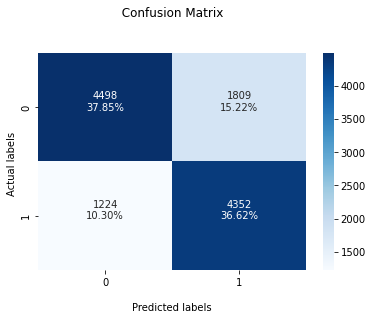

In [ ]:
plot_confusion_matrix(y_val_label_FS,y_pred_validation_XGB_tfidf_FS_T1)

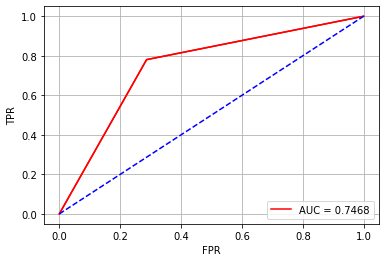

In [ ]:
plot_roc_curve(y_val_label_FS,y_pred_validation_XGB_tfidf_FS_T1)

In [ ]:
y_predict_XGB_tfidf_FS_T1=XGB_tfidf_pipe.predict(x_test_text_FS_k)
y_predict_XGB_tfidf_FS_T1

array([1, 1, 1, ..., 0, 1, 1])

In [ ]:
y_predict_pro_XGB_tfidf_FS_T1=XGB_tfidf_pipe.predict_proba(x_test_text_FS_k)
y_predict_pro_XGB_tfidf_FS_T1

array([[0.475078  , 0.524922  ],
       [0.475078  , 0.524922  ],
       [0.4146577 , 0.5853423 ],
       ...,
       [0.86274683, 0.13725314],
       [0.43050748, 0.5694925 ],
       [0.36332   , 0.63668   ]], dtype=float32)

In [ ]:
id=df_test_K['id']
pred_df = pd.DataFrame(data={'id': np.asarray(id), 'label': y_predict_pro_XGB_tfidf_FS_T1[:,1]})

pred_df.to_csv('XGB_tfidf_FS_T1.csv', index=False)

test (kaggle) score is 80%  

####trial (Pipeline([("tfidf", TfidfVectorizer(ngram_range=(1,3),analyzer="char")), ('XGB', XGBClassifier())])
)

In [ ]:
XGB_tfidf_pipe_T2 = Pipeline([("tfidf", TfidfVectorizer(ngram_range=(1,3),analyzer="char")), ('XGB', XGBClassifier(n_estimators=40,max_depth=20))])
#fit the model and print the score the model
XGB_tfidf_pipe_T2.fit(x_train_text_FS, y_train_label_FS)  

Pipeline(steps=[('tfidf', TfidfVectorizer(analyzer='char', ngram_range=(1, 3))),
                ('XGB', XGBClassifier(max_depth=20, n_estimators=40))])

In [ ]:
XGB_tfidf_pipe_T2.score(x_train_text_FS, y_train_label_FS)

0.97574163686093

In [ ]:
y_pred_validation_XGB_tfidf_FS_T2 = XGB_tfidf_pipe_T2.predict(x_val_text_FS)

In [ ]:
y_pred_validation_XGB_tfidf_FS_T2

array([1, 1, 0, ..., 1, 0, 0])

In [ ]:
#Accuracy
Accuracy=accuracy_score(y_val_label_FS,y_pred_validation_XGB_tfidf_FS_T2) 
print("XGB_FS_T1_Accuracy:  " , (Accuracy))

XGB_FS_T1_Accuracy:   0.8423798704030968


In [ ]:
print(classification_report(y_val_label_FS,y_pred_validation_XGB_tfidf_FS_T2))

              precision    recall  f1-score   support

           0       0.91      0.78      0.84      6307
           1       0.79      0.91      0.84      5576

    accuracy                           0.84     11883
   macro avg       0.85      0.85      0.84     11883
weighted avg       0.85      0.84      0.84     11883



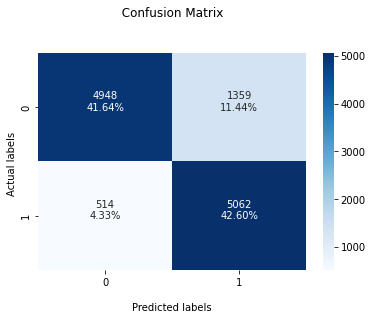

In [ ]:
plot_confusion_matrix(y_val_label_FS,y_pred_validation_XGB_tfidf_FS_T2)

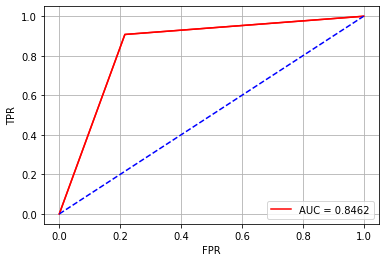

In [ ]:
plot_roc_curve(y_val_label_FS,y_pred_validation_XGB_tfidf_FS_T2)

In [ ]:
y_predict_XGB_tfidf_FS_T2=XGB_tfidf_pipe_T2.predict(x_test_text_FS_k)
y_predict_XGB_tfidf_FS_T2

array([1, 0, 0, ..., 0, 1, 1])

In [ ]:
y_predict_pro_XGB_tfidf_FS_T2=XGB_tfidf_pipe_T2.predict_proba(x_test_text_FS_k)
y_predict_pro_XGB_tfidf_FS_T2

array([[0.34706455, 0.65293545],
       [0.67154765, 0.32845235],
       [0.906536  , 0.09346402],
       ...,
       [0.9113754 , 0.0886246 ],
       [0.3107506 , 0.6892494 ],
       [0.23752606, 0.76247394]], dtype=float32)

In [ ]:
id=df_test_K['id']
pred_df = pd.DataFrame(data={'id': np.asarray(id), 'label': y_predict_pro_XGB_tfidf_FS_T2[:,1]})

pred_df.to_csv('XGB_tfidf_FS_T2.csv', index=False)

test (kaggle) score is 83%

####trial (Hyperparamter search method (grid) with validation set (not cross-validation))

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import PredefinedSplit
# Split Data to Train and Validation
X_train_FS_VS, X_val_FS_VS, y_train_FS_VS, y_val_FS_VS = train_test_split(x_train_text_FS, y_train_label_FS, train_size = 0.8, stratify = y_train_label_FS,random_state =10)

In [ ]:
# Create a list where train data indices are -1 and validation data indices are 0
split_index = [-1 if x in X_train_FS_VS.index else 0 for x in x_train_text_FS.text.index]
# Use the list to create PredefinedSplit
pds = PredefinedSplit(test_fold = split_index)

In [ ]:
# feature creation and modelling in a single function
XGB_tfidf_pipe_GS = Pipeline([("tfidf", TfidfVectorizer()), ('XGB', XGBClassifier())])

# define parameter space to test 
XGB_tfidf_pipe_params = {
    "tfidf__ngram_range": [(1,2),(1, 3)],
    "tfidf__analyzer":["word","char"],
    'XGB__n_estimators': [ 40],  
    'XGB__max_depth':[20] ,
    #"tfidf__max_df": np.arange(0.3, 0.8),
    #"tfidf__min_df": np.arange(5, 10),

}


In [ ]:
#calculate running time
%%time
# Use PredefinedSplit in GridSearchCV
XGB_tfidf_pipe_Grid_clf_FS = GridSearchCV(XGB_tfidf_pipe, XGB_tfidf_pipe_params, cv=pds, verbose=1, n_jobs=2, scoring="f1_macro")
XGB_tfidf_pipe_Grid_clf_FS.fit(x_train_text_FS, y_train_label_FS)

In [ ]:
print('best params {}'.format(XGB_tfidf_pipe_Grid_clf_FS.best_params_))
print('best score {}'.format(XGB_tfidf_pipe_Grid_clf_FS.best_score_))
print('best estimator {}'.format(XGB_tfidf_pipe_Grid_clf_FS.best_estimator_))

In [ ]:
# run pipe with optimized parameters
XGB_tfidf_pipe_Grid_clf_FS.best_estimator_.fit(x_train_text_FS, y_train_label_FS)

In [ ]:
XGB_tfidf_pipe_Grid_clf_FS.best_estimator_.score(x_train_text_FS, y_train_label_FS)

In [ ]:
y_pred_validation_XGB_tfidf_pipe_GS_FS =XGB_tfidf_pipe_Grid_clf_FS.best_estimator_.predict(x_val_text_FS)

In [ ]:
y_pred_validation_XGB_tfidf_pipe_GS_FS

In [ ]:
#Accuracy
Accuracy=accuracy_score(y_val_FS,y_pred_validation_XGB_tfidf_pipe_GS_FS) 
print("XGB_tfidf_pipe_GS_Accuracy:  " , (Accuracy))

In [ ]:
print(classification_report(y_val_FS,y_pred_validation_XGB_tfidf_pipe_GS_FS))

In [ ]:
plot_confusion_matrix(y_val_FS,y_pred_validation_XGB_tfidf_pipe_GS_FS)

In [ ]:
plot_roc_curve(y_val_FS,y_pred_validation_XGB_tfidf_pipe_GS_FS)

In [ ]:
y_predict_XGB_tfidf_pipe_GS_FS=XGB_tfidf_pipe_Grid_clf_FS.best_estimator_.predict(x_test_text_FS_k)
y_predict_XGB_tfidf_pipe_GS_FS

In [ ]:
y_predict_pro_XGB_tfidf_pipe_GS_FS=XGB_tfidf_pipe_Grid_clf_FS.best_estimator_.predict_proba(x_test_text_FS_k)
y_predict_pro_XGB_tfidf_pipe_GS_FS

In [ ]:
id=df_test_K['id']
pred_df = pd.DataFrame(data={'id': np.asarray(id), 'label': y_predict_pro_XGB_tfidf_pipe_GS_FS[:,1]})

pred_df.to_csv('XGB_tfidf_pipe_GS_FS.csv', index=False)

####trial (Pipeline([("tfidf", TfidfVectorizer(ngram_range=(1,3),analyzer="word")), ('LogisticRegression', LogisticRegression())]))

In [ ]:
LR_tfidf_pipe = Pipeline([("tfidf", TfidfVectorizer(ngram_range=(1,2),analyzer="word")), ('LogisticRegression', LogisticRegression())])
#fit the model and print the score the model
LR_tfidf_pipe.fit(x_train_text_FS, y_train_label_FS)  

Pipeline(steps=[('tfidf', TfidfVectorizer(ngram_range=(1, 2))),
                ('LogisticRegression', LogisticRegression())])

In [ ]:
LR_tfidf_pipe.score(x_train_text_FS, y_train_label_FS)

0.9201556911424363

In [ ]:
y_pred_validation_LR_tfidf_FS_T1 = LR_tfidf_pipe.predict(x_val_text_FS)

In [ ]:
y_pred_validation_LR_tfidf_FS_T1

array([0, 1, 1, ..., 1, 0, 0])

In [ ]:
#Accuracy
Accuracy=accuracy_score(y_val_label_FS,y_pred_validation_LR_tfidf_FS_T1) 
print("LR_FS_T1_Accuracy:  " , (Accuracy))

LR_FS_T1_Accuracy:   0.8135992594462678


In [ ]:
print(classification_report(y_val_label_FS,y_pred_validation_LR_tfidf_FS_T1))

              precision    recall  f1-score   support

           0       0.82      0.82      0.82      6307
           1       0.80      0.80      0.80      5576

    accuracy                           0.81     11883
   macro avg       0.81      0.81      0.81     11883
weighted avg       0.81      0.81      0.81     11883



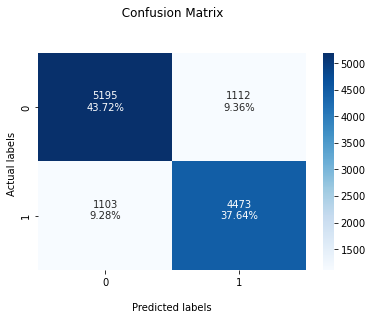

In [ ]:
plot_confusion_matrix(y_val_label_FS,y_pred_validation_LR_tfidf_FS_T1)

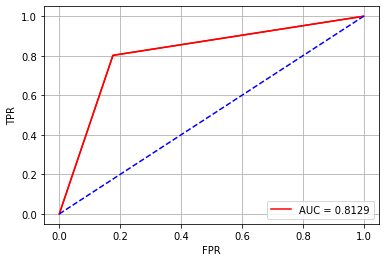

In [ ]:
plot_roc_curve(y_val_label_FS,y_pred_validation_LR_tfidf_FS_T1)

In [ ]:
y_predict_LR_tfidf_FS_T1=LR_tfidf_pipe.predict(x_test_text_FS_k)
y_predict_LR_tfidf_FS_T1

array([0, 0, 1, ..., 0, 0, 1])

In [ ]:
y_predict_pro_LR_tfidf_FS_T1=LR_tfidf_pipe.predict_proba(x_test_text_FS_k)
y_predict_pro_LR_tfidf_FS_T1

array([[0.5321868 , 0.4678132 ],
       [0.77959028, 0.22040972],
       [0.36386385, 0.63613615],
       ...,
       [0.75814064, 0.24185936],
       [0.75012882, 0.24987118],
       [0.23412592, 0.76587408]])

In [ ]:
id=df_test_K['id']
pred_df = pd.DataFrame(data={'id': np.asarray(id), 'label': y_predict_pro_LR_tfidf_FS_T1[:,1]})

pred_df.to_csv('LR_tfidf_FS_T1.csv', index=False)

test (kaggle) score is 87%

####trial (Pipeline([("tfidf", TfidfVectorizer(ngram_range=(1,2),analyzer="word")), ('LogisticRegression', LogisticRegression())]))

In [ ]:
LR_tfidf_pipe_T2 = Pipeline([("tfidf", TfidfVectorizer(ngram_range=(1,2),analyzer="word")), ('LogisticRegression', LogisticRegression())])
#fit the model and print the score the model
LR_tfidf_pipe_T2.fit(x_train_text_FS, y_train_label_FS)  

Pipeline(steps=[('tfidf', TfidfVectorizer(ngram_range=(1, 2))),
                ('LogisticRegression', LogisticRegression())])

In [ ]:
LR_tfidf_pipe_T2.score(x_train_text_FS, y_train_label_FS)

0.9201556911424363

In [ ]:
y_pred_validation_LR_tfidf_FS_T2 = LR_tfidf_pipe_T2.predict(x_val_text_FS)

In [ ]:
y_pred_validation_LR_tfidf_FS_T2

array([0, 1, 1, ..., 1, 0, 0])

In [ ]:
#Accuracy
Accuracy=accuracy_score(y_val_label_FS,y_pred_validation_LR_tfidf_FS_T2) 
print("XGB_FS_T1_Accuracy:  " , (Accuracy))

XGB_FS_T1_Accuracy:   0.8135992594462678


In [ ]:
print(classification_report(y_val_label_FS,y_pred_validation_LR_tfidf_FS_T2))

              precision    recall  f1-score   support

           0       0.82      0.82      0.82      6307
           1       0.80      0.80      0.80      5576

    accuracy                           0.81     11883
   macro avg       0.81      0.81      0.81     11883
weighted avg       0.81      0.81      0.81     11883



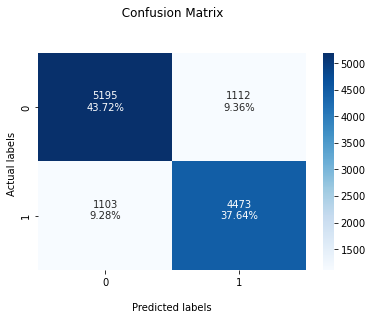

In [ ]:
plot_confusion_matrix(y_val_label_FS,y_pred_validation_LR_tfidf_FS_T2)

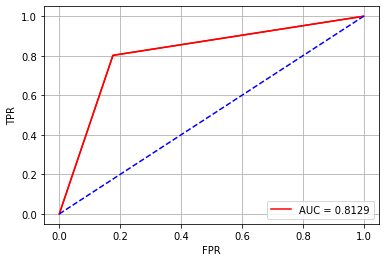

In [ ]:
plot_roc_curve(y_val_label_FS,y_pred_validation_LR_tfidf_FS_T2)

In [ ]:
y_predict_LR_tfidf_FS_T2=LR_tfidf_pipe_T2.predict(x_test_text_FS_k)
y_predict_LR_tfidf_FS_T2

array([0, 0, 1, ..., 0, 0, 1])

In [ ]:
y_predict_pro_LR_tfidf_FS_T2=LR_tfidf_pipe_T2.predict_proba(x_test_text_FS_k)
y_predict_pro_LR_tfidf_FS_T2

array([[0.5321868 , 0.4678132 ],
       [0.77959028, 0.22040972],
       [0.36386385, 0.63613615],
       ...,
       [0.75814064, 0.24185936],
       [0.75012882, 0.24987118],
       [0.23412592, 0.76587408]])

In [ ]:
id=df_test_K['id']
pred_df = pd.DataFrame(data={'id': np.asarray(id), 'label': y_predict_pro_LR_tfidf_FS_T2[:,1]})

pred_df.to_csv('LR_tfidf_FS_T2.csv', index=False)

test (kaggle) score is 87%

####trial (Hyperparamter search method (random) with ( cross-validation))

In [ ]:
# feature creation and modelling in a single function
LR_tfidf_pipe = Pipeline([("tfidf", TfidfVectorizer()), ("log", LogisticRegression())])

# define parameter space to test 
LR_tfidf_pipe_params = {
    "tfidf__ngram_range": [(1, 2), (1, 3)],
    "tfidf__analyzer":["word","char"],
    "tfidf__max_df": np.arange(0.3, 0.8),
    "tfidf__min_df": np.arange(5, 100),
    'log__penalty':['l1','l2'],
    'log__C':[1,1e2, 1e3,1e5],
    'log__max_iter':[100,1000,10000],

}

In [ ]:
#calculate running time
%%time
LR_tfidf_pipe_RS_FS = RandomizedSearchCV(LR_tfidf_pipe, LR_tfidf_pipe_params, cv=5, verbose=1, n_jobs=2, scoring="f1_macro")
LR_tfidf_pipe_RS_FS.fit(x_train_text_FS, y_train_label_FS)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
10 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  Fil

CPU times: user 19.4 s, sys: 758 ms, total: 20.1 s
Wall time: 7min 28s


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                             ('log', LogisticRegression())]),
                   n_jobs=2,
                   param_distributions={'log__C': [1, 100.0, 1000.0, 100000.0],
                                        'log__max_iter': [100, 1000, 10000],
                                        'log__penalty': ['l1', 'l2'],
                                        'tfidf__analyzer': ['word', 'char'],
                                        'tfidf__max_df': array([0.3]),
                                        'tfidf__min_df': array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21,
       22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38,
       39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55,
       56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72,
       73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86

In [ ]:
print('best params {}'.format(LR_tfidf_pipe_RS_FS.best_params_))
print('best score {}'.format(LR_tfidf_pipe_RS_FS.best_score_))
print('best estimator {}'.format(LR_tfidf_pipe_RS_FS.best_estimator_))

best params {'tfidf__ngram_range': (1, 3), 'tfidf__min_df': 36, 'tfidf__max_df': 0.3, 'tfidf__analyzer': 'char', 'log__penalty': 'l2', 'log__max_iter': 1000, 'log__C': 1}
best score 0.8458410174211737


In [ ]:
# run pipe with optimized parameters
LR_tfidf_pipe_RS_FS.best_estimator_.fit(x_train_text_FS, y_train_label_FS)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(analyzer='char', max_df=0.3, min_df=36,
                                 ngram_range=(1, 3))),
                ('log', LogisticRegression(C=1, max_iter=1000))])

In [ ]:
LR_tfidf_pipe_RS_FS.best_estimator_.score(x_train_text_FS, y_train_label_FS)

0.8734273090679571

In [ ]:
y_pred_validation_LR_tfidf_pipe_RS_FS =LR_tfidf_pipe_RS_FS.best_estimator_.predict(x_val_text_FS)

In [ ]:
y_pred_validation_LR_tfidf_pipe_RS_FS

array([0, 1, 0, ..., 1, 0, 1])

In [ ]:
#Accuracy
Accuracy=accuracy_score(y_val_label_FS,y_pred_validation_LR_tfidf_pipe_RS_FS) 
print("XGB_tfidf_pipe_GS_Accuracy:  " , (Accuracy))

XGB_tfidf_pipe_GS_Accuracy:   0.847429100395523


In [ ]:
print(classification_report(y_val_label_FS,y_pred_validation_LR_tfidf_pipe_RS_FS))

              precision    recall  f1-score   support

           0       0.87      0.83      0.85      6307
           1       0.82      0.86      0.84      5576

    accuracy                           0.85     11883
   macro avg       0.85      0.85      0.85     11883
weighted avg       0.85      0.85      0.85     11883



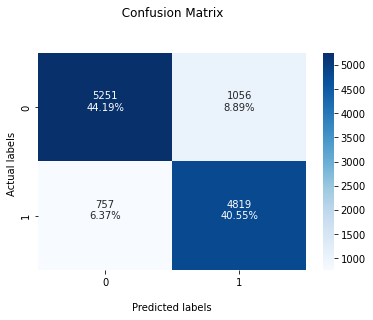

In [ ]:
plot_confusion_matrix(y_val_label_FS,y_pred_validation_LR_tfidf_pipe_RS_FS)

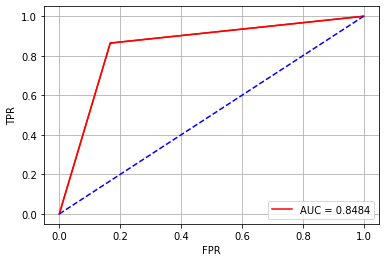

In [ ]:
plot_roc_curve(y_val_label_FS,y_pred_validation_LR_tfidf_pipe_RS_FS)

In [ ]:
y_predict_LR_tfidf_pipe_RS_FS=LR_tfidf_pipe_RS_FS.best_estimator_.predict(x_test_text_FS_k)
y_predict_LR_tfidf_pipe_RS_FS

array([1, 1, 1, ..., 0, 0, 1])

In [ ]:
y_predict_pro_LR_tfidf_pipe_RS_FS=LR_tfidf_pipe_RS_FS.best_estimator_.predict_proba(x_test_text_FS_k)
y_predict_pro_LR_tfidf_pipe_RS_FS

array([[0.26805341, 0.73194659],
       [0.24956933, 0.75043067],
       [0.43756005, 0.56243995],
       ...,
       [0.85267404, 0.14732596],
       [0.66200423, 0.33799577],
       [0.08451054, 0.91548946]])

In [ ]:
id=df_test_K['id']
pred_df = pd.DataFrame(data={'id': np.asarray(id), 'label': y_predict_pro_LR_tfidf_pipe_RS_FS[:,1]})

pred_df.to_csv('LR_tfidf_pipe_RS_FS.csv', index=False)

test (kaggle) score is 82%

####trial (Pipeline([("tfidf", TfidfVectorizer(ngram_range=(1,2),analyzer="word")), ('RandomForestClassifier', RandomForestClassifier())]))

In [ ]:
RF_tfidf_pipe = Pipeline([("tfidf", TfidfVectorizer(ngram_range=(1,2),analyzer="word")), ('RandomForestClassifier', RandomForestClassifier())])
#fit the model and print the score the model
RF_tfidf_pipe.fit(x_train_text_FS, y_train_label_FS)  

Pipeline(steps=[('tfidf', TfidfVectorizer(ngram_range=(1, 2))),
                ('RandomForestClassifier', RandomForestClassifier())])

In [ ]:
RF_tfidf_pipe.score(x_train_text_FS, y_train_label_FS)

0.9999789606564276

In [ ]:
y_pred_validation_RF_tfidf_FS_T1 = RF_tfidf_pipe.predict(x_val_text_FS)

In [ ]:
y_pred_validation_RF_tfidf_FS_T1

array([0, 1, 1, ..., 1, 0, 0])

In [ ]:
#Accuracy
Accuracy=accuracy_score(y_val_label_FS,y_pred_validation_RF_tfidf_FS_T1) 
print("RF_tfidf_FS_T1_Accuracy:  " , (Accuracy))

RF_tfidf_FS_T1_Accuracy:   0.7864175713203736


In [ ]:
print(classification_report(y_val_label_FS,y_pred_validation_RF_tfidf_FS_T1))

              precision    recall  f1-score   support

           0       0.81      0.78      0.79      6307
           1       0.76      0.80      0.78      5576

    accuracy                           0.79     11883
   macro avg       0.79      0.79      0.79     11883
weighted avg       0.79      0.79      0.79     11883



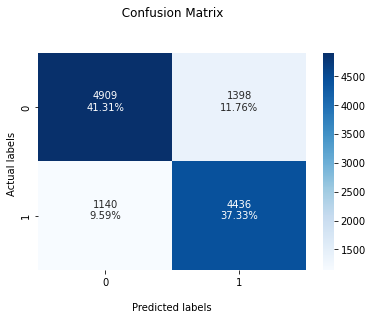

In [ ]:
plot_confusion_matrix(y_val_label_FS,y_pred_validation_RF_tfidf_FS_T1)

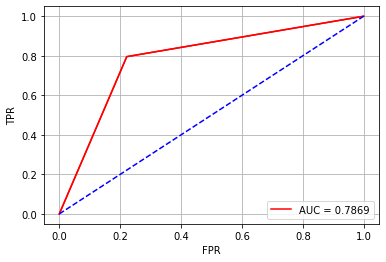

In [ ]:
plot_roc_curve(y_val_label_FS,y_pred_validation_RF_tfidf_FS_T1)

In [ ]:
y_predict_RF_tfidf_FS_T1=RF_tfidf_pipe.predict(x_test_text_FS_k)
y_predict_RF_tfidf_FS_T1

array([0, 0, 1, ..., 0, 0, 1])

In [ ]:
y_predict_pro_RF_tfidf_FS_T1=RF_tfidf_pipe.predict_proba(x_test_text_FS_k)
y_predict_pro_RF_tfidf_FS_T1

array([[0.95, 0.05],
       [0.95, 0.05],
       [0.3 , 0.7 ],
       ...,
       [0.69, 0.31],
       [0.64, 0.36],
       [0.32, 0.68]])

In [ ]:
id=df_test_K['id']
pred_df = pd.DataFrame(data={'id': np.asarray(id), 'label': y_predict_pro_RF_tfidf_FS_T1[:,1]})

pred_df.to_csv('RF_tfidf_FS_T1.csv', index=False)

test (kaggle) score is 88%

####trial (Pipeline([("tfidf", TfidfVectorizer(ngram_range=(1,3),analyzer="char")), ('RandomForestClassifier', RandomForestClassifier())]))

In [ ]:
RF_tfidf_pipe_T2 = Pipeline([("tfidf", TfidfVectorizer(ngram_range=(1,3),analyzer="char")), ('RandomForestClassifier', RandomForestClassifier())])
#fit the model and print the score the model
RF_tfidf_pipe_T2.fit(x_train_text_FS, y_train_label_FS)  

Pipeline(steps=[('tfidf', TfidfVectorizer(analyzer='char', ngram_range=(1, 3))),
                ('RandomForestClassifier', RandomForestClassifier())])

In [ ]:
RF_tfidf_pipe_T2.score(x_train_text_FS, y_train_label_FS)

1.0

In [ ]:
y_pred_validation_RF_tfidf_FS_T2 = RF_tfidf_pipe_T2.predict(x_val_text_FS)

In [ ]:
y_pred_validation_RF_tfidf_FS_T2

array([0, 1, 0, ..., 1, 0, 0])

In [ ]:
#Accuracy
Accuracy=accuracy_score(y_val_label_FS,y_pred_validation_RF_tfidf_FS_T2) 
print("RF_tfidf_pipe_T2_Accuracy:  " , (Accuracy))

RF_tfidf_pipe_T2_Accuracy:   0.8166287974417235


In [ ]:
print(classification_report(y_val_label_FS,y_pred_validation_RF_tfidf_FS_T2))

              precision    recall  f1-score   support

           0       0.87      0.78      0.82      6307
           1       0.77      0.86      0.82      5576

    accuracy                           0.82     11883
   macro avg       0.82      0.82      0.82     11883
weighted avg       0.82      0.82      0.82     11883



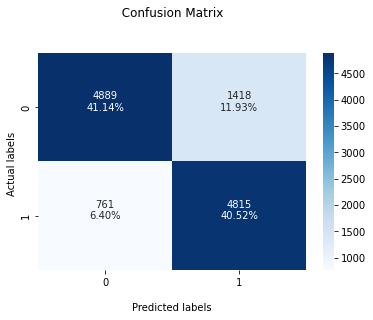

In [ ]:
plot_confusion_matrix(y_val_label_FS,y_pred_validation_RF_tfidf_FS_T2)

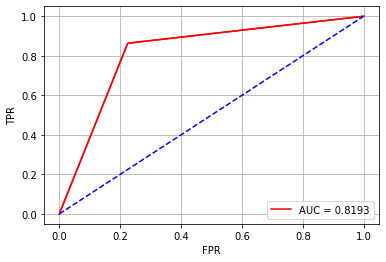

In [ ]:
plot_roc_curve(y_val_label_FS,y_pred_validation_RF_tfidf_FS_T2)

In [ ]:
y_predict_RF_tfidf_FS_T2=RF_tfidf_pipe_T2.predict(x_test_text_FS_k)
y_predict_RF_tfidf_FS_T2

array([0, 0, 0, ..., 0, 1, 1])

In [ ]:
y_predict_pro_RF_tfidf_FS_T2=RF_tfidf_pipe_T2.predict_proba(x_test_text_FS_k)
y_predict_pro_RF_tfidf_FS_T2

In [ ]:
id=df_test_K['id']
pred_df = pd.DataFrame(data={'id': np.asarray(id), 'label': y_predict_pro_RF_tfidf_FS_T2[:,1]})

pred_df.to_csv('RF_tfidf_FS_T2.csv', index=False)

test (kaggle ) score is 89% (is the highest score)

##Second Solution

the Second solution is applying preprocessing that(check missing values and any dublicate and remove rows with dupliacte valus and check distribution of the target column and remove any rows with not proper label (remove any rows with label=2)and check quality(balance) of data ) and apply  text preprocessing for "text" column(apply stemming method, remove any html tags,Keep only ASCII + European Chars and whitespace, remove single letter chars)

###Data cleaning for training data 

In [ ]:
df_SS=pd.read_csv('xy_train.csv')

In [ ]:
df_SS.shape

(60000, 3)

In [ ]:
df_SS.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      60000 non-null  int64 
 1   text    60000 non-null  object
 2   label   60000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.4+ MB


In [ ]:
df_SS.head()

,id,text,label
0,265723,A group of friends began to volunteer at a hom...,0
1,284269,British Prime Minister @Theresa_May on Nerve A...,0
2,207715,"In 1961, Goodyear released a kit that allows P...",0
3,551106,"Happy Birthday, Bob Barker! The Price Is Right...",0
4,8584,"Obama to Nation: 聙""Innocent Cops and Unarmed Y...",0


In [ ]:
#Check the data for missing values in training data
df_SS.isnull().sum()

id       0
text     0
label    0
dtype: int64

In [ ]:
#Check the data for duplicates 
df_SS.duplicated().any()

False

In [ ]:
df_SS.shape

(60000, 3)

In [ ]:
#lets drop duplicates (if any)
df_SS.drop_duplicates(inplace=True)

In [ ]:
df_SS.shape

(60000, 3)

####label

In [ ]:
#check the target column 
df_SS['label'].value_counts()

0    32172
1    27596
2      232
Name: label, dtype: int64

In [ ]:
# Distribution of label
df_SS["label"].value_counts(normalize=True)

0    0.536200
1    0.459933
2    0.003867
Name: label, dtype: float64

In [ ]:
df_SS.shape

(60000, 3)

In [ ]:
#"label" should be 0 or 1 so drop any row when "label"=2
df_SS = df_SS[df_SS.label != 2]

In [ ]:
df_SS.shape

(59768, 3)

In [ ]:
#check the target column 
df_SS['label'].value_counts()

0    32172
1    27596
Name: label, dtype: int64

In [ ]:
# Distribution of label
df_SS["label"].value_counts(normalize=True)

0    0.538281
1    0.461719
Name: label, dtype: float64

the data is balance 

####text

In [ ]:
#describe the text column
df_SS['text'].describe()

count                                                 59768
unique                                                59413
top       /r/Fakehistoryporn subscribers as they attempt...
freq                                                     14
Name: text, dtype: object

text has 59645 unique values out of 60000 rows so we have a duplicated values so drop these rows

In [ ]:
df_SS['text'].duplicated().sum()

355

In [ ]:
#Remove the duplicated rows
df_SS.drop_duplicates('text',inplace = True)

In [ ]:
df_SS.shape

(59413, 3)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from xgboost import XGBClassifier
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
import nltk 


In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
stemmer = SnowballStemmer("english")
stop_words = set(stopwords.words("english"))

def clean_text(text):
    RE_WSPACE = re.compile(r"\s+", re.IGNORECASE)
    RE_TAGS = re.compile(r"<[^>]+>")
    RE_ASCII = re.compile(r"[^A-Za-zÀ-ž ]", re.IGNORECASE)
    RE_SINGLECHAR = re.compile(r"\b[A-Za-zÀ-ž]\b", re.IGNORECASE)
    #RE_TWOCHARACTER=re.compile(r"\b[A-Za-zÀ-ž]\b{2}", re.IGNORECASE)
    #RE_URL=re.compile(r'^https?:\/\/.*[\r\n]*', re.IGNORECASE)

    #remove any html tags (< /br> often found)
    text = re.sub(RE_TAGS, " ", text)
    #Keep only ASCII + European Chars and whitespace, no digits
    text = re.sub(RE_ASCII, " ", text)
    #remove single letter chars
    text = re.sub(RE_SINGLECHAR, " ", text)
     #remove two letter chars
    #text = re.sub(RE_TWOCHARACTER, " ", text)
    #remove URL 
    #text = re.sub(RE_URL, " ", text)
    #convert all whitespaces (tabs etc.) to single wspace
    text = re.sub(RE_WSPACE, " ", text)
    #remove any digit
    text=re.sub(r'\d+', '', text)

    word_tokens = word_tokenize(text)
    words_tokens_lower = [word.lower() for word in word_tokens]
      # (tdf-idf):
      # remove stopwords, punctuation and stemm
    words_filtered = [
      stemmer.stem(word) for word in words_tokens_lower if word not in stop_words
        ]
    text_clean = " ".join(words_filtered)
    return text_clean

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Clean text
df_SS["text_clean"] = df_SS.loc[df_SS["text"].str.len() > 0, "text"]
df_SS["text_clean"] = df_SS["text_clean"].map(
    lambda x: clean_text(x) if isinstance(x, str) else x
)

In [ ]:
df_SS.head()

,id,text,label,text_clean
0,265723,A group of friends began to volunteer at a hom...,0,group friend began volunt homeless shelter nei...
1,284269,British Prime Minister @Theresa_May on Nerve A...,0,british prime minist theresa may nerv attack f...
2,207715,"In 1961, Goodyear released a kit that allows P...",0,goodyear releas kit allow ps brought heel http...
3,551106,"Happy Birthday, Bob Barker! The Price Is Right...",0,happi birthday bob barker price right host lik...
4,8584,"Obama to Nation: 聙""Innocent Cops and Unarmed Y...",0,obama nation innoc cop unarm young black men d...


In [ ]:
df_SS.shape

(59413, 4)

In [ ]:
# Drop when any of x missing
df_SS = df_SS[(df_SS["text_clean"] != "") & (df_SS["text_clean"] != "null")]

df_SS = df_SS.dropna(
    axis="index", subset=[ "text", "text_clean"]
).reset_index(drop=True)

In [ ]:
df_SS.shape

(59403, 4)

In [ ]:
from bokeh.models import NumeralTickFormatter
# Word Frequency of most common words
word_freq = pd.Series(" ".join(df_SS["text_clean"]).split()).value_counts()
word_freq[1:40]

one         3274
like        3117
new         2972
look        2839
color       2725
man         2717
get         2593
trump       2552
say         2322
peopl       2311
use         2302
first       2232
make        2222
old         2216
time        2018
poster      1999
found       1996
day         1926
war         1851
post        1614
world       1565
work        1527
show        1506
us          1496
american    1489
take        1482
life        1478
psbattl     1467
help        1439
go          1413
state       1403
back        1363
two         1357
school      1334
see         1322
made        1310
save        1306
photo       1288
right       1276
dtype: int64

In [ ]:
# list most uncommon words
word_freq[-10:].reset_index(name="freq")

,index,freq
0,clo,1
1,hatsun,1
2,nfler,1
3,hicock,1
4,mccall,1
5,angriff,1
6,kutemey,1
7,ollow,1
8,valdiserri,1
9,wahr,1


###Data cleaning for test data (kaggle)

In [ ]:
df_test_k_SS=pd.read_csv('x_test.csv')

In [ ]:
df_test_k_SS.shape

(59151, 2)

In [ ]:
df_test_k_SS.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59151 entries, 0 to 59150
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      59151 non-null  int64 
 1   text    59151 non-null  object
dtypes: int64(1), object(1)
memory usage: 924.4+ KB


In [ ]:
df_test_k_SS.head()

,id,text
0,0,stargazer
1,1,yeah
2,2,PD: Phoenix car thief gets instructions from Y...
3,3,"As Trump Accuses Iran, He Has One Problem: His..."
4,4,"""Believers"" - Hezbollah 2011"


In [ ]:
# Clean text
df_test_k_SS["text_clean"] = df_test_k_SS.loc[df_test_k_SS["text"].str.len() > 0, "text"]
df_test_k_SS["text_clean"] = df_test_k_SS["text_clean"].map(
    lambda x: clean_text(x) if isinstance(x, str) else x
)

In [ ]:
df_test_k_SS.head()

,id,text,text_clean
0,0,stargazer,stargaz
1,1,yeah,yeah
2,2,PD: Phoenix car thief gets instructions from Y...,pd phoenix car thief get instruct youtub video
3,3,"As Trump Accuses Iran, He Has One Problem: His...",trump accus iran one problem credibl
4,4,"""Believers"" - Hezbollah 2011",believ hezbollah


In [ ]:
x_test_text_SS_k = df_test_k_SS.text_clean

In [ ]:
df_test_k_SS.shape

(59151, 3)

###split the data

In [ ]:
from sklearn.model_selection import train_test_split
# split data (training/testing set)
df_train_SS, df_val_SS = train_test_split(df_SS, test_size=0.2, random_state=10)

In [ ]:
x_train_text_SS = df_train_SS.text_clean
y_train_label_SS = df_train_SS.label
x_val_text_SS = df_val_SS.text_clean
y_val_label_SS = df_val_SS.label

In [ ]:
print("x_train_text_SS.shape >>>> ",x_train_text_SS.shape)
print("y_train_label_SS.shape >>>> ",y_train_label_SS.shape)
print("x_val_text_SS.shape >>>> ",x_val_text_SS.shape)
print("y_val_label_SS.shape >>>> ",y_val_label_SS.shape)

x_train_text_SS.shape >>>>  (47522,)
y_train_label_SS.shape >>>>  (47522,)
x_val_text_SS.shape >>>>  (11881,)
y_val_label_SS.shape >>>>  (11881,)


###trials

####trial (Pipeline([("tfidf", TfidfVectorizer(ngram_range=(1,2),analyzer="word")), ('XGB', XGBClassifier())]))


In [ ]:
XGB_tfidf_pipe = Pipeline([("tfidf", TfidfVectorizer(ngram_range=(1,2),analyzer="word")), ('XGB', XGBClassifier())])
#fit the model and print the score the model
XGB_tfidf_pipe.fit(x_train_text_SS, y_train_label_SS)  

Pipeline(steps=[('tfidf', TfidfVectorizer(ngram_range=(1, 2))),
                ('XGB', XGBClassifier())])

In [ ]:
XGB_tfidf_pipe.score(x_train_text_SS, y_train_label_SS)

0.6827995454736754

In [ ]:
y_pred_validation_XGB_tfidf_SS_T1 = XGB_tfidf_pipe.predict(x_val_text_SS)

In [ ]:
y_pred_validation_XGB_tfidf_SS_T1

array([0, 0, 0, ..., 0, 0, 1])

In [ ]:
#Accuracy
Accuracy=accuracy_score(y_val_label_SS,y_pred_validation_XGB_tfidf_SS_T1) 
print("XGB_SS_T1_Accuracy:  " , (Accuracy))

XGB_SS_T1_Accuracy:   0.6649271946805825


In [ ]:
print(classification_report(y_val_label_SS,y_pred_validation_XGB_tfidf_SS_T1))

              precision    recall  f1-score   support

           0       0.64      0.86      0.73      6413
           1       0.72      0.44      0.55      5468

    accuracy                           0.66     11881
   macro avg       0.68      0.65      0.64     11881
weighted avg       0.68      0.66      0.65     11881



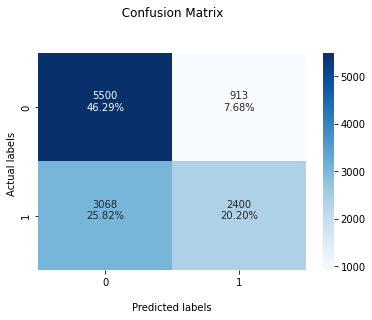

In [ ]:
plot_confusion_matrix(y_val_label_SS,y_pred_validation_XGB_tfidf_SS_T1)

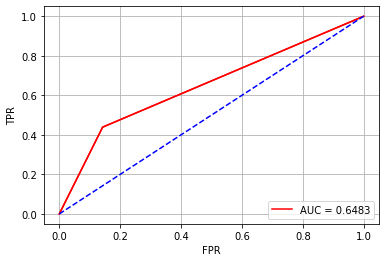

In [ ]:
plot_roc_curve(y_val_label_SS,y_pred_validation_XGB_tfidf_SS_T1)

In [ ]:
y_predict_XGB_tfidf_SS_T1=XGB_tfidf_pipe.predict(x_test_text_SS_k)
y_predict_XGB_tfidf_SS_T1

array([0, 0, 1, ..., 0, 0, 1])

In [ ]:
y_predict_pro_XGB_tfidf_SS_T1=XGB_tfidf_pipe.predict_proba(x_test_text_SS_k)
y_predict_pro_XGB_tfidf_SS_T1

array([[0.5139333 , 0.4860667 ],
       [0.5139333 , 0.4860667 ],
       [0.46868318, 0.5313168 ],
       ...,
       [0.7556793 , 0.24432069],
       [0.5139333 , 0.4860667 ],
       [0.46868318, 0.5313168 ]], dtype=float32)

In [ ]:
id=df_test_K['id']
pred_df = pd.DataFrame(data={'id': np.asarray(id), 'label': y_predict_pro_XGB_tfidf_SS_T1[:,1]})

pred_df.to_csv('XGB_tfidf_SS_T1.csv', index=False)

the test (Kaggle) score is 72%

####trial (Pipeline([("tfidf", TfidfVectorizer(ngram_range=(1,3),analyzer="char")), ('XGB', XGBClassifier())]))


In [ ]:
XGB_tfidf_pipe_T2 = Pipeline([("tfidf", TfidfVectorizer(ngram_range=(1,3),analyzer="char")), ('XGB', XGBClassifier())])
#fit the model and print the score the model
XGB_tfidf_pipe_T2.fit(x_train_text_SS, y_train_label_SS)  

Pipeline(steps=[('tfidf', TfidfVectorizer(analyzer='char', ngram_range=(1, 3))),
                ('XGB', XGBClassifier())])

In [ ]:
XGB_tfidf_pipe_T2.score(x_train_text_SS, y_train_label_SS)

0.7142586591473423

In [ ]:
y_pred_validation_XGB_tfidf_SS_T2 = XGB_tfidf_pipe_T2.predict(x_val_text_SS)

In [ ]:
y_pred_validation_XGB_tfidf_SS_T2

array([0, 1, 0, ..., 1, 1, 1])

In [ ]:
#Accuracy
Accuracy=accuracy_score(y_val_label_SS,y_pred_validation_XGB_tfidf_SS_T2) 
print("XGB_FS_T2_Accuracy:  " , (Accuracy))

XGB_FS_T2_Accuracy:   0.6915242824678057


In [ ]:
print(classification_report(y_val_label_SS,y_pred_validation_XGB_tfidf_SS_T2))

              precision    recall  f1-score   support

           0       0.70      0.74      0.72      6413
           1       0.68      0.63      0.65      5468

    accuracy                           0.69     11881
   macro avg       0.69      0.69      0.69     11881
weighted avg       0.69      0.69      0.69     11881



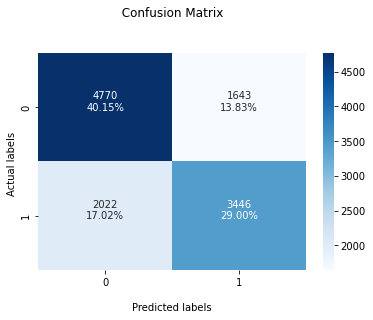

In [ ]:
plot_confusion_matrix(y_val_label_SS,y_pred_validation_XGB_tfidf_SS_T2)

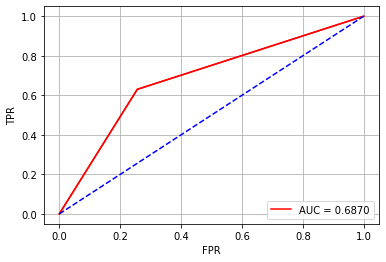

In [ ]:
plot_roc_curve(y_val_label_SS,y_pred_validation_XGB_tfidf_SS_T2)

In [ ]:
y_predict_XGB_tfidf_SS_T2=XGB_tfidf_pipe_T2.predict(x_test_text_SS_k)
y_predict_XGB_tfidf_SS_T2

array([0, 1, 0, ..., 0, 0, 1])

In [ ]:
y_predict_pro_XGB_tfidf_SS_T2=XGB_tfidf_pipe_T2.predict_proba(x_test_text_SS_k)
y_predict_pro_XGB_tfidf_SS_T2

array([[0.55770284, 0.44229716],
       [0.4674477 , 0.5325523 ],
       [0.52854085, 0.47145918],
       ...,
       [0.84473586, 0.15526411],
       [0.5070845 , 0.49291554],
       [0.46661842, 0.5333816 ]], dtype=float32)

In [ ]:
id=df_test_K['id']
pred_df = pd.DataFrame(data={'id': np.asarray(id), 'label': y_predict_pro_XGB_tfidf_SS_T2[:,1]})

pred_df.to_csv('XGB_tfidf_SS_T2.csv', index=False)

the test (kaggle) score is 80%

####trial (Hyperparamter search method (grid) with validation set (not cross-validation))

In [ ]:
df_SS.shape

(59413, 3)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import PredefinedSplit
# Split Data to Train and Validation
X_train_SS_VS, X_val_SS_VS, y_train_SS_VS, y_val_SS_VS = train_test_split(df_SS.text, df_SS.label, train_size = 0.8, stratify = df_SS.label,random_state =10)

In [ ]:
print("X_train_SS_VS.shape >>>> ",X_train_SS_VS.shape)
print("y_train_SS_VS.shape >>>> ",y_train_SS_VS.shape)
print("X_val_SS_VS.shape >>>> ",X_val_SS_VS.shape)
print("y_val_SS_VS.shape >>>> ",y_val_SS_VS.shape)

X_train_FS_VS.shape >>>>  (47530,)
y_train_FS_VS.shape >>>>  (47530,)
X_val_FS_VS.shape >>>>  (11883,)
y_val_FS_VS.shape >>>>  (11883,)


In [ ]:
# Create a list where train data indices are -1 and validation data indices are 0
split_index = [-1 if x in X_train_SS_VS.index else 0 for x in df_SS.text.index]
# Use the list to create PredefinedSplit
pds = PredefinedSplit(test_fold = split_index)

In [ ]:
# feature creation and modelling in a single function
XGB_tfidf_pipe_GS = Pipeline([("tfidf", TfidfVectorizer()), ('XGB', XGBClassifier())])

# define parameter space to test 
XGB_tfidf_pipe_params = {
    "tfidf__ngram_range": [(1,2),(1, 3)],
    "tfidf__analyzer":["word","char"],
    'XGB__n_estimators': [ 40],  
    'XGB__max_depth':[20] ,
    #"tfidf__max_df": np.arange(0.3, 0.8),
    #"tfidf__min_df": np.arange(5, 10),

}


In [ ]:
#calculate running time
%%time
# Use PredefinedSplit in GridSearchCV
XGB_tfidf_pipe_Grid_clf_SS = GridSearchCV(XGB_tfidf_pipe, XGB_tfidf_pipe_params, cv=pds, verbose=1, n_jobs=2, scoring="f1_macro")
XGB_tfidf_pipe_Grid_clf_SS.fit(X_train_SS_VS, y_train_SS_VS)


In [ ]:
print('best params {}'.format(XGB_tfidf_pipe_Grid_clf_SS.best_params_))
print('best score {}'.format(XGB_tfidf_pipe_Grid_clf_SS.best_score_))

In [ ]:
# run pipe with optimized parameters
XGB_tfidf_pipe_GS.set_params(**XGB_tfidf_pipe_Grid_clf_SS.best_params_).fit(X_train_SS_VS, y_train_SS_VS)

In [ ]:
XGB_tfidf_pipe_GS.set_params(**XGB_tfidf_pipe_Grid_clf_SS.best_params_).score(X_train_SS_VS, y_train_SS_VS)

In [ ]:
y_pred_validation_XGB_tfidf_pipe_GS_SS =XGB_tfidf_pipe_GS.set_params(**XGB_tfidf_pipe_Grid_clf_SS.best_params_).predict(x_val_text_SS)

In [ ]:
y_pred_validation_XGB_tfidf_pipe_GS_SS

In [ ]:
#Accuracy
Accuracy=accuracy_score(y_val_SS_VS,y_pred_validation_XGB_tfidf_pipe_GS_SS) 
print("XGB_tfidf_pipe_GS_Accuracy:  " , (Accuracy))

In [ ]:
print(classification_report(y_val_SS_VS,y_pred_validation_XGB_tfidf_pipe_GS_SS))

In [ ]:
plot_confusion_matrix(y_val_SS_VS,y_pred_validation_XGB_tfidf_pipe_GS_SS)

In [ ]:
plot_roc_curve(y_val_SS_VS,y_pred_validation_XGB_tfidf_pipe_GS_SS)

In [ ]:
y_predict_XGB_tfidf_pipe_GS_SS=XGB_tfidf_pipe_GS.set_params(**XGB_tfidf_pipe_Grid_clf_SS.best_params_).predict(x_test_text_SS_k)
y_predict_XGB_tfidf_pipe_GS_SS

In [ ]:
y_predict_pro_XGB_tfidf_pipe_GS_SS=XGB_tfidf_pipe_GS.set_params(**XGB_tfidf_pipe_Grid_clf_SS.best_params_).predict_proba(x_test_text_SS_k)
y_predict_pro_XGB_tfidf_pipe_GS_SS

In [ ]:
id=df_test_K['id']
pred_df = pd.DataFrame(data={'id': np.asarray(id), 'label': y_predict_pro_XGB_tfidf_pipe_GS_SS[:,1]})

pred_df.to_csv('XGB_tfidf_pipe_GS_SS.csv', index=False)

####trial (Pipeline([("tfidf", TfidfVectorizer(ngram_range=(1,2),analyzer="word")), ('LogisticRegression', LogisticRegression())])

In [ ]:
LR_tfidf_pipe = Pipeline([("tfidf", TfidfVectorizer(ngram_range=(1,2),analyzer="word")), ('LogisticRegression', LogisticRegression())])
#fit the model and print the score the model
LR_tfidf_pipe.fit(x_train_text_SS, y_train_label_SS)  

Pipeline(steps=[('tfidf', TfidfVectorizer(ngram_range=(1, 2))),
                ('LogisticRegression', LogisticRegression())])

In [ ]:
LR_tfidf_pipe.score(x_train_text_SS, y_train_label_SS)

0.9114515382349228

In [ ]:
y_pred_validation_LR_tfidf_SS_T1 = LR_tfidf_pipe.predict(x_val_text_SS)

In [ ]:
y_pred_validation_LR_tfidf_SS_T1

array([0, 1, 1, ..., 1, 1, 1])

In [ ]:
#Accuracy
Accuracy=accuracy_score(y_val_label_SS,y_pred_validation_LR_tfidf_SS_T1) 
print("LR_SS_T1_Accuracy:  " , (Accuracy))

LR_SS_T1_Accuracy:   0.786886625704907


In [ ]:
print(classification_report(y_val_label_SS,y_pred_validation_LR_tfidf_SS_T1))

              precision    recall  f1-score   support

           0       0.81      0.79      0.80      6413
           1       0.76      0.78      0.77      5468

    accuracy                           0.79     11881
   macro avg       0.79      0.79      0.79     11881
weighted avg       0.79      0.79      0.79     11881



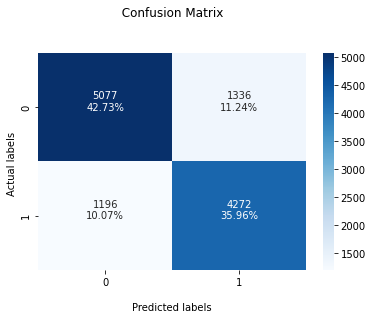

In [ ]:
plot_confusion_matrix(y_val_label_SS,y_pred_validation_LR_tfidf_SS_T1)

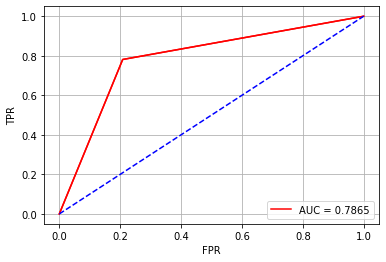

In [ ]:
plot_roc_curve(y_val_label_SS,y_pred_validation_LR_tfidf_SS_T1)

In [ ]:
y_predict_LR_tfidf_SS_T1=LR_tfidf_pipe.predict(x_test_text_SS_k)
y_predict_LR_tfidf_SS_T1

array([0, 0, 0, ..., 0, 0, 1])

In [ ]:
y_predict_pro_LR_tfidf_SS_T1=LR_tfidf_pipe.predict_proba(x_test_text_SS_k)
y_predict_pro_LR_tfidf_SS_T1[:,1]

array([0.44426468, 0.21229753, 0.42834761, ..., 0.14166342, 0.3184946 ,
       0.84554526])

In [ ]:
id=df_test_K['id']
pred_df = pd.DataFrame(data={'id': np.asarray(id), 'label': y_predict_pro_LR_tfidf_SS_T1[:,1]})

pred_df.to_csv('LR_tfidf_SS_T1.csv', index=False)

the test (kaggle) score is 84%

the test (kaggle) score is 84%

####trial (Pipeline([("tfidf", TfidfVectorizer(ngram_range=(1,2),analyzer="word")), ('LogisticRegression', LogisticRegression())]))


In [ ]:
LR_tfidf_pipe_T2 = Pipeline([("tfidf", TfidfVectorizer(ngram_range=(1,2),analyzer="word")), ('LogisticRegression', LogisticRegression())])
#fit the model and print the score the model
LR_tfidf_pipe_T2.fit(x_train_text_SS, y_train_label_SS)  

Pipeline(steps=[('tfidf', TfidfVectorizer(ngram_range=(1, 2))),
                ('LogisticRegression', LogisticRegression())])

In [ ]:
LR_tfidf_pipe_T2.score(x_train_text_SS, y_train_label_SS)

0.9114515382349228

In [ ]:
y_pred_validation_LR_tfidf_SS_T2 = LR_tfidf_pipe_T2.predict(x_val_text_SS)

In [ ]:
y_pred_validation_LR_tfidf_SS_T2

array([0, 1, 1, ..., 1, 1, 1])

In [ ]:
#Accuracy
Accuracy=accuracy_score(y_val_label_SS,y_pred_validation_LR_tfidf_SS_T2) 
print("LR_tfidf_SS_T2_Accuracy:  " , (Accuracy))

LR_tfidf_SS_T2_Accuracy:   0.786886625704907


In [ ]:
print(classification_report(y_val_label_SS,y_pred_validation_LR_tfidf_SS_T2))

              precision    recall  f1-score   support

           0       0.81      0.79      0.80      6413
           1       0.76      0.78      0.77      5468

    accuracy                           0.79     11881
   macro avg       0.79      0.79      0.79     11881
weighted avg       0.79      0.79      0.79     11881



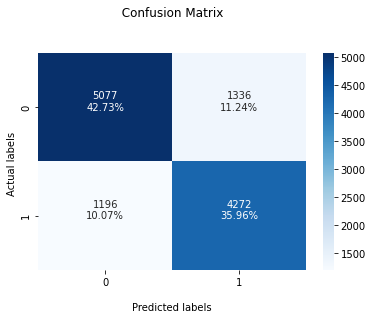

In [ ]:
plot_confusion_matrix(y_val_label_SS,y_pred_validation_LR_tfidf_SS_T2)

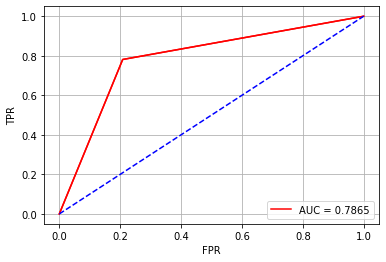

In [ ]:
plot_roc_curve(y_val_label_SS,y_pred_validation_LR_tfidf_SS_T2)

In [ ]:
y_predict_LR_tfidf_SS_T2=LR_tfidf_pipe_T2.predict(x_test_text_SS_k)
y_predict_LR_tfidf_SS_T2

array([0, 0, 0, ..., 0, 0, 1])

In [ ]:
y_predict_pro_LR_tfidf_SS_T2=LR_tfidf_pipe_T2.predict_proba(x_test_text_SS_k)
y_predict_pro_LR_tfidf_SS_T2

array([[0.55573532, 0.44426468],
       [0.78770247, 0.21229753],
       [0.57165239, 0.42834761],
       ...,
       [0.85833658, 0.14166342],
       [0.6815054 , 0.3184946 ],
       [0.15445474, 0.84554526]])

In [ ]:
id=df_test_K['id']
pred_df = pd.DataFrame(data={'id': np.asarray(id), 'label': y_predict_pro_LR_tfidf_SS_T2[:,1]})

pred_df.to_csv('LR_tfidf_SS_T2.csv', index=False)

the test (kaggle) score is 84%

the test (kaggle) score is 84%

####trial (Hyperparamter search method (random) with ( cross-validation))

In [ ]:
# feature creation and modelling in a single function
LR_tfidf_pipe = Pipeline([("tfidf", TfidfVectorizer()), ("log", LogisticRegression())])

# define parameter space to test 
LR_tfidf_pipe_params = {
    "tfidf__ngram_range": [(1, 2), (1, 3)],
    "tfidf__analyzer":["word","char"],
    "tfidf__max_df": np.arange(0.3, 0.8),
    "tfidf__min_df": np.arange(5, 100),
    'log__penalty':['l1','l2'],
    'log__C':[1,1e2, 1e3,1e5],
    'log__max_iter':[100,1000,10000],

}

In [ ]:
#calculate running time
%%time
LR_tfidf_pipe_RS_SS = RandomizedSearchCV(LR_tfidf_pipe, LR_tfidf_pipe_params, cv=5, verbose=1, n_jobs=2, scoring="f1_macro")
LR_tfidf_pipe_RS_SS.fit(x_train_text_SS, y_train_label_SS)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
25 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  Fil

CPU times: user 7.23 s, sys: 617 ms, total: 7.85 s
Wall time: 5min 15s


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                             ('log', LogisticRegression())]),
                   n_jobs=2,
                   param_distributions={'log__C': [1, 100.0, 1000.0, 100000.0],
                                        'log__max_iter': [100, 1000, 10000],
                                        'log__penalty': ['l1', 'l2'],
                                        'tfidf__analyzer': ['word', 'char'],
                                        'tfidf__max_df': array([0.3]),
                                        'tfidf__min_df': array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21,
       22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38,
       39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55,
       56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72,
       73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86

In [ ]:
print('best params {}'.format(LR_tfidf_pipe_RS_SS.best_params_))
print('best score {}'.format(LR_tfidf_pipe_RS_SS.best_score_))

best params {'tfidf__ngram_range': (1, 2), 'tfidf__min_df': 41, 'tfidf__max_df': 0.3, 'tfidf__analyzer': 'word', 'log__penalty': 'l2', 'log__max_iter': 10000, 'log__C': 1}
best score 0.7677288145161596


In [ ]:
# run pipe with optimized parameters
LR_tfidf_pipe.set_params(**LR_tfidf_pipe_RS_SS.best_params_).fit(x_train_text_SS, y_train_label_SS)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.3, min_df=41, ngram_range=(1, 2))),
                ('log', LogisticRegression(C=1, max_iter=10000))])

In [ ]:
LR_tfidf_pipe.score(x_train_text_SS, y_train_label_SS)

0.8024914776314128

In [ ]:
y_pred_validation_LR_tfidf_pipe_RS_SS =LR_tfidf_pipe.set_params(**LR_tfidf_pipe_RS_SS.best_params_).predict(x_val_text_SS)

In [ ]:
y_pred_validation_LR_tfidf_pipe_RS_SS

array([0, 1, 1, ..., 1, 1, 1])

In [ ]:
#Accuracy
Accuracy=accuracy_score(y_val_label_SS,y_pred_validation_LR_tfidf_pipe_RS_SS) 
print("XGB_tfidf_pipe_GS_Accuracy:  " , (Accuracy))

XGB_tfidf_pipe_GS_Accuracy:   0.7724097298207222


In [ ]:
print(classification_report(y_val_label_SS,y_pred_validation_LR_tfidf_pipe_RS_SS))

              precision    recall  f1-score   support

           0       0.79      0.79      0.79      6413
           1       0.75      0.75      0.75      5468

    accuracy                           0.77     11881
   macro avg       0.77      0.77      0.77     11881
weighted avg       0.77      0.77      0.77     11881



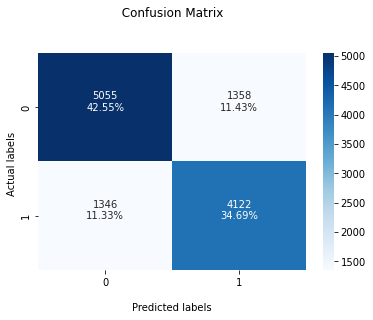

In [ ]:
plot_confusion_matrix(y_val_label_SS,y_pred_validation_LR_tfidf_pipe_RS_SS)

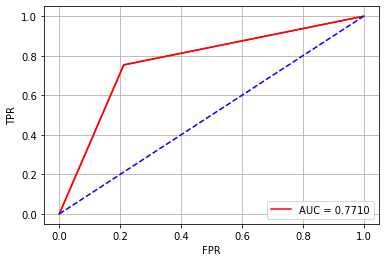

In [ ]:
plot_roc_curve(y_val_label_SS,y_pred_validation_LR_tfidf_pipe_RS_SS)

In [ ]:
y_predict_LR_tfidf_pipe_RS_SS=LR_tfidf_pipe.set_params(**LR_tfidf_pipe_RS_SS.best_params_).predict(x_test_text_SS_k)
y_predict_LR_tfidf_pipe_RS_SS

array([0, 0, 0, ..., 0, 0, 1])

In [ ]:
y_predict_pro_LR_tfidf_pipe_RS_SS=LR_tfidf_pipe.set_params(**LR_tfidf_pipe_RS_SS.best_params_).predict_proba(x_test_text_SS_k)
y_predict_pro_LR_tfidf_pipe_RS_SS

array([[0.56118521, 0.43881479],
       [0.80830473, 0.19169527],
       [0.52219186, 0.47780814],
       ...,
       [0.92802137, 0.07197863],
       [0.8454082 , 0.1545918 ],
       [0.13845181, 0.86154819]])

In [ ]:
id=df_test_K['id']
pred_df = pd.DataFrame(data={'id': np.asarray(id), 'label': y_predict_pro_LR_tfidf_pipe_RS_SS[:,1]})

pred_df.to_csv('LR_tfidf_pipe_RS_SS.csv', index=False)

the test (kaggle) score is 83%

####trial (Pipeline([("tfidf", TfidfVectorizer(ngram_range=(1,2),analyzer="word")), ('RandomForestClassifier', RandomForestClassifier())]))


In [ ]:
RF_tfidf_pipe = Pipeline([("tfidf", TfidfVectorizer(ngram_range=(1,2),analyzer="word")), ('RandomForestClassifier', RandomForestClassifier())])
#fit the model and print the score the model
RF_tfidf_pipe.fit(x_train_text_SS, y_train_label_SS)  

Pipeline(steps=[('tfidf', TfidfVectorizer(ngram_range=(1, 2))),
                ('RandomForestClassifier', RandomForestClassifier())])

In [ ]:
RF_tfidf_pipe.score(x_train_text_SS, y_train_label_SS)

0.9999789571145996

In [ ]:
y_pred_validation_RF_tfidf_SS_T1 = RF_tfidf_pipe.predict(x_val_text_SS)

In [ ]:
y_pred_validation_RF_tfidf_SS_T1

array([0, 1, 0, ..., 1, 1, 1])

In [ ]:
#Accuracy
Accuracy=accuracy_score(y_val_label_SS,y_pred_validation_RF_tfidf_SS_T1) 
print("RF_tfidf_SS_T1_Accuracy:  " , (Accuracy))

RF_tfidf_SS_T1_Accuracy:   0.7634879218920966


In [ ]:
print(classification_report(y_val_label_SS,y_pred_validation_RF_tfidf_SS_T1))

              precision    recall  f1-score   support

           0       0.78      0.78      0.78      6413
           1       0.75      0.74      0.74      5468

    accuracy                           0.76     11881
   macro avg       0.76      0.76      0.76     11881
weighted avg       0.76      0.76      0.76     11881



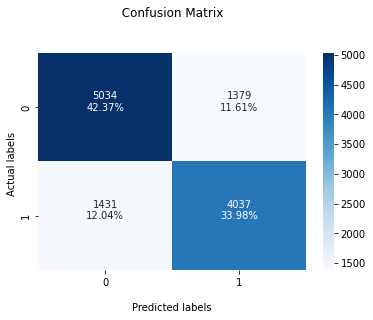

In [ ]:
plot_confusion_matrix(y_val_label_SS,y_pred_validation_RF_tfidf_SS_T1)

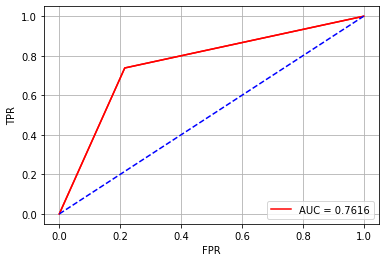

In [ ]:
plot_roc_curve(y_val_label_SS,y_pred_validation_RF_tfidf_SS_T1,)

In [ ]:
y_predict_RF_tfidf_SS_T1=RF_tfidf_pipe.predict(x_test_text_SS_k)
y_predict_RF_tfidf_SS_T1

array([0, 0, 0, ..., 0, 0, 1])

In [ ]:
y_predict_pro_RF_tfidf_SS_T1=RF_tfidf_pipe.predict_proba(x_test_text_SS_k)
y_predict_pro_RF_tfidf_SS_T1

array([[1.  , 0.  ],
       [0.96, 0.04],
       [0.56, 0.44],
       ...,
       [0.73, 0.27],
       [0.86, 0.14],
       [0.25, 0.75]])

In [ ]:
id=df_test_K['id']
pred_df = pd.DataFrame(data={'id': np.asarray(id), 'label': y_predict_pro_RF_tfidf_SS_T1[:,1]})

pred_df.to_csv('RF_tfidf_SS_T1.csv', index=False)

the test (kaggle) score is 87%

####trial (Pipeline([("tfidf", TfidfVectorizer(ngram_range=(1,3),analyzer="char")), ('RandomForestClassifier', RandomForestClassifier())]))


In [ ]:
RF_tfidf_pipe_T2 = Pipeline([("tfidf", TfidfVectorizer(ngram_range=(1,3),analyzer="char")), ('RandomForestClassifier', RandomForestClassifier())])
#fit the model and print the score the model
RF_tfidf_pipe_T2.fit(x_train_text_SS, y_train_label_SS)  

Pipeline(steps=[('tfidf', TfidfVectorizer(analyzer='char', ngram_range=(1, 3))),
                ('RandomForestClassifier', RandomForestClassifier())])

In [ ]:
RF_tfidf_pipe_T2.score(x_train_text_SS, y_train_label_SS)

0.9999789571145996

In [ ]:
y_pred_validation_RF_tfidf_SS_T2 = RF_tfidf_pipe_T2.predict(x_val_text_SS)

In [ ]:
y_pred_validation_RF_tfidf_SS_T2

array([1, 0, 1, ..., 1, 1, 1])

In [ ]:
#Accuracy
Accuracy=accuracy_score(y_val_label_SS,y_pred_validation_RF_tfidf_SS_T2) 
print("RF_tfidf_pipe_T2_Accuracy:  " , (Accuracy))

RF_tfidf_pipe_T2_Accuracy:   0.7005302583957579


In [ ]:
print(classification_report(y_val_label_SS,y_pred_validation_RF_tfidf_SS_T2))

              precision    recall  f1-score   support

           0       0.70      0.78      0.74      6413
           1       0.70      0.60      0.65      5468

    accuracy                           0.70     11881
   macro avg       0.70      0.69      0.69     11881
weighted avg       0.70      0.70      0.70     11881



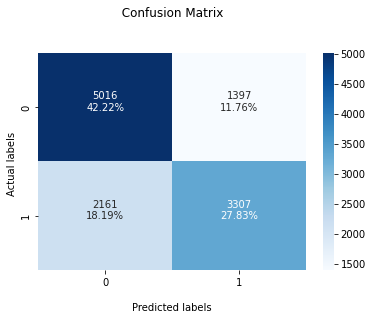

In [ ]:
plot_confusion_matrix(y_val_label_SS,y_pred_validation_RF_tfidf_SS_T2)

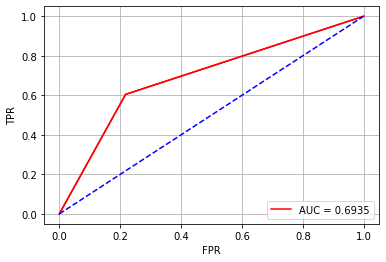

In [ ]:
plot_roc_curve(y_val_label_SS,y_pred_validation_RF_tfidf_SS_T2)

In [ ]:
y_predict_RF_tfidf_SS_T2=RF_tfidf_pipe_T2.predict(x_test_text_SS_k)
y_predict_RF_tfidf_SS_T2

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
y_predict_pro_RF_tfidf_SS_T2=RF_tfidf_pipe_T2.predict_proba(x_test_text_SS_k)
y_predict_pro_RF_tfidf_SS_T2

array([[0.71, 0.29],
       [0.8 , 0.2 ],
       [0.63, 0.37],
       ...,
       [0.66, 0.34],
       [0.57, 0.43],
       [0.51, 0.49]])

In [ ]:
id=df_test_K['id']
pred_df = pd.DataFrame(data={'id': np.asarray(id), 'label': y_predict_pro_RF_tfidf_SS_T2[:,1]})

pred_df.to_csv('RF_tfidf_SS_T2.csv', index=False)

the test (kaggle) score is 85%

##Third Solution

the third solution is applying preprocessing that(check missing values and any dublicate and remove rows with dupliacte valus and check distribution of the target column and remove any rows with not proper label (remove any rows with label=2)and check quality(balance) of data ) and apply  text preprocessing for "text" column(apply lemmatization method, remove any html tags,Keep only ASCII + European Chars and whitespace, remove single letter chars)

###Data cleaning for training data 

In [ ]:
df_TS=pd.read_csv('xy_train.csv')

In [ ]:
df_TS.shape

(60000, 3)

In [ ]:
df_TS.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      60000 non-null  int64 
 1   text    60000 non-null  object
 2   label   60000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.4+ MB


In [ ]:
df_TS.head()

,id,text,label
0,265723,A group of friends began to volunteer at a hom...,0
1,284269,British Prime Minister @Theresa_May on Nerve A...,0
2,207715,"In 1961, Goodyear released a kit that allows P...",0
3,551106,"Happy Birthday, Bob Barker! The Price Is Right...",0
4,8584,"Obama to Nation: 聙""Innocent Cops and Unarmed Y...",0


In [ ]:
#Check the data for missing values in training data
df_TS.isnull().sum()

id       0
text     0
label    0
dtype: int64

In [ ]:
#Check the data for duplicates 
df_TS.duplicated().any()

False

In [ ]:
df_TS.shape

(60000, 3)

In [ ]:
#lets drop duplicates (if any)
df_TS.drop_duplicates(inplace=True)

In [ ]:
df_TS.shape

(60000, 3)

####label

In [ ]:
#check the target column 
df_TS['label'].value_counts()

0    32172
1    27596
2      232
Name: label, dtype: int64

In [ ]:
# Distribution of label
df_TS["label"].value_counts(normalize=True)

0    0.536200
1    0.459933
2    0.003867
Name: label, dtype: float64

In [ ]:
df_TS.shape

(60000, 3)

In [ ]:
#"label" should be 0 or 1 so drop any row when "label"=2
df_TS = df_TS[df_TS.label != 2]

In [ ]:
df_TS.shape

(59768, 3)

In [ ]:
#check the target column 
df_TS['label'].value_counts()

0    32172
1    27596
Name: label, dtype: int64

In [ ]:
# Distribution of label
df_TS["label"].value_counts(normalize=True)

0    0.538281
1    0.461719
Name: label, dtype: float64

the data is balance 

####text

In [ ]:
#describe the text column
df_TS['text'].describe()

count                                                 59768
unique                                                59413
top       /r/Fakehistoryporn subscribers as they attempt...
freq                                                     14
Name: text, dtype: object

text has 59413 unique values out of 59768 rows so we have a duplicated values so drop these rows

In [ ]:
df_TS['text'].duplicated().sum()

355

In [ ]:
#Remove the duplicated rows
df_TS.drop_duplicates('text',inplace = True)

In [ ]:
df_TS.shape

(59413, 3)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from xgboost import XGBClassifier
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
import nltk 
from nltk.stem import WordNetLemmatizer



In [ ]:
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))

def clean_text_TS(text):
    RE_WSPACE = re.compile(r"\s+", re.IGNORECASE)
    RE_TAGS = re.compile(r"<[^>]+>")
    RE_ASCII = re.compile(r"[^A-Za-zÀ-ž ]", re.IGNORECASE)
    RE_SINGLECHAR = re.compile(r"\b[A-Za-zÀ-ž]\b", re.IGNORECASE)
    #RE_TWOCHARACTER=re.compile(r"\b[A-Za-zÀ-ž]\b{2}", re.IGNORECASE)
    #RE_URL=re.compile(r'^https?:\/\/.*[\r\n]*', re.IGNORECASE)
    
   # remove any html tags (< /br> often found)
    text = re.sub(RE_TAGS, " ", text)
    #Keep only ASCII + European Chars and whitespace, no digits
    text = re.sub(RE_ASCII, " ", text)
    #remove single letter chars
    text = re.sub(RE_SINGLECHAR, " ", text)
     #remove two letter chars
    #text = re.sub(RE_TWOCHARACTER, " ", text)
    #remove URL 
    #text = re.sub(RE_URL, " ", text)
    #convert all whitespaces (tabs etc.) to single wspace
    text = re.sub(RE_WSPACE, " ", text)
    #remove any digit
    text=re.sub(r'\d+', '', text)

    word_tokens = word_tokenize(text)
    words_tokens_lower = [word.lower() for word in word_tokens]

    
    # (tdf-idf):
    # - remove stopwords, punctuation and stemm
    words_filtered = [
           lemmatizer.lemmatize(word) for word in words_tokens_lower if word not in stop_words
        ]

    text_clean = " ".join(words_filtered)
    return text_clean

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
# Clean text
df_TS["text_clean"] = df_TS.loc[df_TS["text"].str.len() > 0, "text"]
df_TS["text_clean"] = df_TS["text_clean"].map(
    lambda x: clean_text_TS(x) if isinstance(x, str) else x
)

In [ ]:
df_TS.head()

,id,text,label,text_clean
0,265723,A group of friends began to volunteer at a hom...,0,group friend began volunteer homeless shelter ...
1,284269,British Prime Minister @Theresa_May on Nerve A...,0,british prime minister theresa may nerve attac...
2,207715,"In 1961, Goodyear released a kit that allows P...",0,goodyear released kit allows p brought heel ht...
3,551106,"Happy Birthday, Bob Barker! The Price Is Right...",0,happy birthday bob barker price right host lik...
4,8584,"Obama to Nation: 聙""Innocent Cops and Unarmed Y...",0,obama nation innocent cop unarmed young black ...


In [ ]:
df_TS.shape

(59413, 4)

In [ ]:
# Drop when any of x missing
df_TS = df_TS[(df_TS["text_clean"] != "") & (df_TS["text_clean"] != "null")]

df_TS = df_TS.dropna(
    axis="index", subset=[ "text", "text_clean"]
).reset_index(drop=True)

In [ ]:
df_TS.shape

(59403, 4)

In [ ]:
from bokeh.models import NumeralTickFormatter
# Word Frequency of most common words
word_freq = pd.Series(" ".join(df_TS["text_clean"]).split()).value_counts()
word_freq[1:40]

one          3274
new          2972
like         2939
man          2694
trump        2551
colorized    2419
people       2310
first        2231
old          2212
look         2208
say          2123
get          2063
time         2002
poster       1998
found        1956
day          1926
woman        1882
war          1851
life         1763
make         1726
world        1565
u            1496
american     1483
psbattle     1465
state        1381
two          1357
post         1351
school       1328
back         1319
made         1310
photo        1288
right        1266
circa        1246
child        1207
president    1194
see          1175
house        1171
know         1167
way          1160
dtype: int64

In [ ]:
# list most uncommon words
word_freq[-10:].reset_index(name="freq")

,index,freq
0,hybernate,1
1,tardigrade,1
2,upriver,1
3,rohl,1
4,squinted,1
5,steinway,1
6,koulibaly,1
7,billionth,1
8,gilmour,1
9,wahre,1


###Data cleaning for test data (kaggle)

In [ ]:
df_test_TS_K=pd.read_csv('x_test.csv')

In [ ]:
df_test_TS_K.shape

(59151, 2)

In [ ]:
df_test_TS_K.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59151 entries, 0 to 59150
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      59151 non-null  int64 
 1   text    59151 non-null  object
dtypes: int64(1), object(1)
memory usage: 924.4+ KB


In [ ]:
df_test_TS_K.head()

,id,text
0,0,stargazer
1,1,yeah
2,2,PD: Phoenix car thief gets instructions from Y...
3,3,"As Trump Accuses Iran, He Has One Problem: His..."
4,4,"""Believers"" - Hezbollah 2011"


In [ ]:
# Clean text
df_test_TS_K["text_clean"] = df_test_TS_K.loc[df_test_TS_K["text"].str.len() > 0, "text"]
df_test_TS_K["text_clean"] = df_test_TS_K["text_clean"].map(
    lambda x: clean_text_TS(x) if isinstance(x, str) else x
)

In [ ]:
df_test_TS_K.head()

,id,text,text_clean
0,0,stargazer,stargazer
1,1,yeah,yeah
2,2,PD: Phoenix car thief gets instructions from Y...,pd phoenix car thief get instruction youtube v...
3,3,"As Trump Accuses Iran, He Has One Problem: His...",trump accuses iran one problem credibility
4,4,"""Believers"" - Hezbollah 2011",believer hezbollah


In [ ]:
x_test_text_TS_k = df_test_TS_K.text_clean

###split the data

In [ ]:
from sklearn.model_selection import train_test_split
# split data (training/testing set)
df_train_TS, df_val_TS = train_test_split(df_TS, test_size=0.2, random_state=10)

In [ ]:
x_train_text_TS = df_train_TS.text_clean
y_train_label_TS = df_train_TS.label
x_val_text_TS = df_val_TS.text_clean
y_val_label_TS = df_val_TS.label

In [ ]:
print("x_train_text_TS.shape >>>> ",x_train_text_TS.shape)
print("y_train_label_TS.shape >>>> ",y_train_label_TS.shape)
print("x_val_text_TS.shape >>>> ",x_val_text_TS.shape)
print("y_val_label_TS.shape >>>> ",y_val_label_TS.shape)

x_train_text_TS.shape >>>>  (47522,)
y_train_label_TS.shape >>>>  (47522,)
x_val_text_TS.shape >>>>  (11881,)
y_val_label_TS.shape >>>>  (11881,)


###trials

####trial (Pipeline([("tfidf", TfidfVectorizer(ngram_range=(1,2),analyzer="word")), ('XGB', XGBClassifier())]))


In [ ]:
XGB_tfidf_pipe = Pipeline([("tfidf", TfidfVectorizer(ngram_range=(1,2),analyzer="word")), ('XGB', XGBClassifier())])
#fit the model and print the score the model
XGB_tfidf_pipe.fit(x_train_text_TS, y_train_label_TS)  

Pipeline(steps=[('tfidf', TfidfVectorizer(ngram_range=(1, 2))),
                ('XGB', XGBClassifier())])

In [ ]:
XGB_tfidf_pipe.score(x_train_text_TS, y_train_label_TS)

0.6765498085097429

In [ ]:
y_pred_validation_XGB_tfidf_TS_T1 = XGB_tfidf_pipe.predict(x_val_text_TS)

In [ ]:
y_pred_validation_XGB_tfidf_TS_T1

array([0, 0, 0, ..., 0, 0, 1])

In [ ]:
#Accuracy
Accuracy=accuracy_score(y_val_label_TS,y_pred_validation_XGB_tfidf_TS_T1) 
print("XGB_TS_T1_Accuracy:  " , (Accuracy))

XGB_TS_T1_Accuracy:   0.6559212187526302


In [ ]:
print(classification_report(y_val_label_TS,y_pred_validation_XGB_tfidf_TS_T1))

              precision    recall  f1-score   support

           0       0.63      0.87      0.73      6413
           1       0.73      0.41      0.52      5468

    accuracy                           0.66     11881
   macro avg       0.68      0.64      0.63     11881
weighted avg       0.67      0.66      0.63     11881



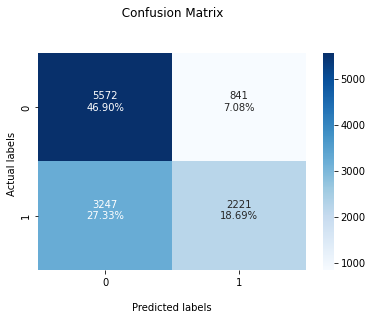

In [ ]:
plot_confusion_matrix(y_val_label_TS,y_pred_validation_XGB_tfidf_TS_T1)

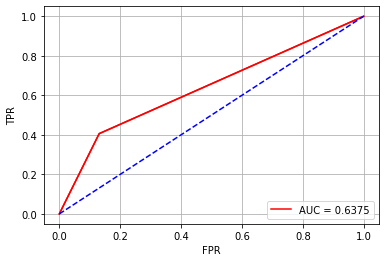

In [ ]:
plot_roc_curve(y_val_label_TS,y_pred_validation_XGB_tfidf_TS_T1)

In [ ]:
y_predict_XGB_tfidf_TS_T1=XGB_tfidf_pipe.predict(x_test_text_TS_k)
y_predict_XGB_tfidf_TS_T1

array([0, 0, 1, ..., 0, 0, 1])

In [ ]:
y_predict_pro_XGB_tfidf_TS_T1=XGB_tfidf_pipe.predict_proba(x_test_text_TS_k)
y_predict_pro_XGB_tfidf_TS_T1

array([[0.50920266, 0.49079734],
       [0.50920266, 0.49079734],
       [0.4680271 , 0.5319729 ],
       ...,
       [0.7531631 , 0.2468369 ],
       [0.50920266, 0.49079734],
       [0.4680271 , 0.5319729 ]], dtype=float32)

In [ ]:
id=df_test_K['id']
pred_df = pd.DataFrame(data={'id': np.asarray(id), 'label': y_predict_pro_XGB_tfidf_TS_T1[:,1]})

pred_df.to_csv('XGB_tfidf_TS_T1.csv', index=False)

the test (kaggle) Score in this trial is 70%

####trial (Pipeline([("tfidf", TfidfVectorizer(ngram_range=(1,3),analyzer="char")), ('XGB', XGBClassifier())]))


In [ ]:
XGB_tfidf_pipe_T2 = Pipeline([("tfidf", TfidfVectorizer(ngram_range=(1,3),analyzer="char")), ('XGB', XGBClassifier())])
#fit the model and print the score the model
XGB_tfidf_pipe_T2.fit(x_train_text_TS, y_train_label_TS)  

Pipeline(steps=[('tfidf', TfidfVectorizer(analyzer='char', ngram_range=(1, 3))),
                ('XGB', XGBClassifier())])

In [ ]:
XGB_tfidf_pipe_T2.score(x_train_text_TS, y_train_label_TS)

0.7148899457093557

In [ ]:
y_pred_validation_XGB_tfidf_TS_T2 = XGB_tfidf_pipe_T2.predict(x_val_text_TS)

In [ ]:
y_pred_validation_XGB_tfidf_TS_T2

array([1, 1, 1, ..., 0, 0, 1])

In [ ]:
#Accuracy
Accuracy=accuracy_score(y_val_label_TS,y_pred_validation_XGB_tfidf_TS_T2) 
print("XGB_TS_T1_Accuracy:  " , (Accuracy))

XGB_TS_T1_Accuracy:   0.694638498442892


In [ ]:
print(classification_report(y_val_label_TS,y_pred_validation_XGB_tfidf_TS_T2))

              precision    recall  f1-score   support

           0       0.71      0.74      0.72      6413
           1       0.68      0.64      0.66      5468

    accuracy                           0.69     11881
   macro avg       0.69      0.69      0.69     11881
weighted avg       0.69      0.69      0.69     11881



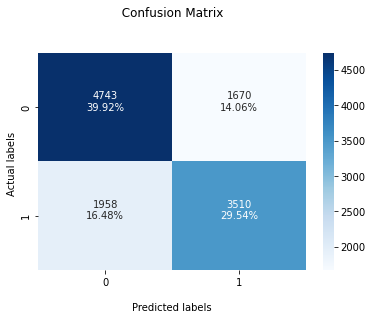

In [ ]:
plot_confusion_matrix(y_val_label_TS,y_pred_validation_XGB_tfidf_TS_T2)

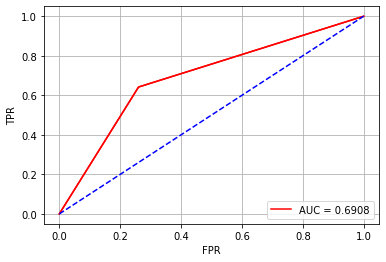

In [ ]:
plot_roc_curve(y_val_label_TS,y_pred_validation_XGB_tfidf_TS_T2)

In [ ]:
y_predict_XGB_tfidf_TS_T2=XGB_tfidf_pipe_T2.predict(x_test_text_TS_k)
y_predict_XGB_tfidf_TS_T2

array([0, 0, 0, ..., 0, 1, 1])

In [ ]:
y_predict_pro_XGB_tfidf_TS_T2=XGB_tfidf_pipe_T2.predict_proba(x_test_text_TS_k)
y_predict_pro_XGB_tfidf_TS_T2

array([[0.58469534, 0.41530463],
       [0.502221  , 0.49777904],
       [0.5542236 , 0.4457764 ],
       ...,
       [0.646323  , 0.35367697],
       [0.464756  , 0.535244  ],
       [0.47157663, 0.52842337]], dtype=float32)

In [ ]:
id=df_test_K['id']
pred_df = pd.DataFrame(data={'id': np.asarray(id), 'label': y_predict_pro_XGB_tfidf_TS_T2[:,1]})

pred_df.to_csv('XGB_tfidf_TS_T2.csv', index=False)

the test (kaggle) Score in this trial is 81%

####trial (Hyperparamter search method (grid) with validation set (not cross-validation))

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import PredefinedSplit
# Split Data to Train and Validation
X_train_TS_VS, X_val_TS_VS, y_train_TS_VS, y_val_TS_VS = train_test_split((x_train_text_TS, y_train_label_TS, train_size = 0.8, stratify = y_train_label_TS,random_state =2022)

In [ ]:
# Create a list where train data indices are -1 and validation data indices are 0
split_index = [-1 if x in X_train_TS_VS.index else 0 for x in x_train_text_TS.index]
# Use the list to create PredefinedSplit
pds = PredefinedSplit(test_fold = split_index)

In [ ]:
# feature creation and modelling in a single function
XGB_tfidf_pipe_GS = Pipeline([("tfidf", TfidfVectorizer()), ('XGB', XGBClassifier())])

# define parameter space to test 
XGB_tfidf_pipe_params = {
    "tfidf__ngram_range": [(1,2),(1, 3)],
    "tfidf__analyzer":["word","char"],
    'XGB__n_estimators': [ 40],  
    'XGB__max_depth':[20] ,
    "tfidf__max_df": np.arange(0.3, 0.8),
    "tfidf__min_df": np.arange(5, 10),

}


In [ ]:
#calculate running time
%%time
# Use PredefinedSplit in GridSearchCV
XGB_tfidf_pipe_Grid_clf_TS = GridSearchCV(XGB_tfidf_pipe, XGB_tfidf_pipe_params, cv=pds, verbose=1, n_jobs=2, scoring="f1_macro")
XGB_tfidf_pipe_Grid_clf_TS.fit(x_train_text_TS, y_train_label_TS)


In [ ]:
print('best params {}'.format(XGB_tfidf_pipe_Grid_clf_TS.best_params_))
print('best score {}'.format(XGB_tfidf_pipe_Grid_clf_TS.best_score_))
print('best estimator {}'.format(XGB_tfidf_pipe_Grid_clf_TS.best_estimator_))

In [ ]:
# run pipe with optimized parameters
XGB_tfidf_pipe_Grid_clf_TS.best_estimator_.fit(x_train_text_TS, y_train_label_TS)

In [ ]:
XGB_tfidf_pipe_Grid_clf_TS.best_estimator_.score(x_train_text_TS, y_train_label_TS)

In [ ]:
y_pred_validation_XGB_tfidf_pipe_GS_TS =XGB_tfidf_pipe_Grid_clf_TS.best_estimator_.predict(x_val_text_TS)

In [ ]:
y_pred_validation_XGB_tfidf_pipe_GS_TS

In [ ]:
#Accuracy
Accuracy=accuracy_score(y_val_label_TS,y_pred_validation_XGB_tfidf_pipe_GS_TS) 
print("XGB_tfidf_pipe_GS_Accuracy:  " , (Accuracy))

In [ ]:
print(classification_report(y_val_label_TS,y_pred_validation_XGB_tfidf_pipe_GS_TS))

In [ ]:
plot_confusion_matrix(y_val_label_TS,y_pred_validation_XGB_tfidf_pipe_GS_TS)

In [ ]:
plot_roc_curve(y_val_label_TS,y_pred_validation_XGB_tfidf_pipe_GS_TS)

In [ ]:
y_predict_XGB_tfidf_pipe_GS_TS=XGB_tfidf_pipe_Grid_clf_TS.best_estimator_.predict(x_test_text_TS_k)
y_predict_XGB_tfidf_pipe_GS_TS

In [ ]:
y_predict_pro_XGB_tfidf_pipe_GS_TS=XGB_tfidf_pipe_Grid_clf_TS.best_estimator_.predict_proba(x_test_text_TS_k)
y_predict_pro_XGB_tfidf_pipe_GS_TS

In [ ]:
id=df_test_K['id']
pred_df = pd.DataFrame(data={'id': np.asarray(id), 'label': y_predict_pro_XGB_tfidf_pipe_GS_TS[:,1]})

pred_df.to_csv('XGB_tfidf_pipe_GS_TS.csv', index=False)

####trial (Pipeline([("tfidf", TfidfVectorizer(ngram_range=(1,2),analyzer="word")), ('LogisticRegression', LogisticRegression())])

In [ ]:
LR_tfidf_pipe = Pipeline([("tfidf", TfidfVectorizer(ngram_range=(1,2),analyzer="word")), ('LogisticRegression', LogisticRegression())])
#fit the model and print the score the model
LR_tfidf_pipe.fit(x_train_text_TS, y_train_label_TS)  

Pipeline(steps=[('tfidf', TfidfVectorizer(ngram_range=(1, 2))),
                ('LogisticRegression', LogisticRegression())])

In [ ]:
LR_tfidf_pipe.score(x_train_text_TS, y_train_label_TS)

0.9197213921972981

In [ ]:
y_pred_validation_LR_tfidf_TS_T1 = LR_tfidf_pipe.predict(x_val_text_TS)

In [ ]:
y_pred_validation_LR_tfidf_TS_T1

array([1, 1, 1, ..., 1, 1, 1])

In [ ]:
#Accuracy
Accuracy=accuracy_score(y_val_label_TS,y_pred_validation_LR_tfidf_TS_T1) 
print("LR_TS_T1_Accuracy:  " , (Accuracy))

LR_TS_T1_Accuracy:   0.786634121706927


In [ ]:
print(classification_report(y_val_label_TS,y_pred_validation_LR_tfidf_TS_T1))

              precision    recall  f1-score   support

           0       0.81      0.79      0.80      6413
           1       0.76      0.78      0.77      5468

    accuracy                           0.79     11881
   macro avg       0.79      0.79      0.79     11881
weighted avg       0.79      0.79      0.79     11881



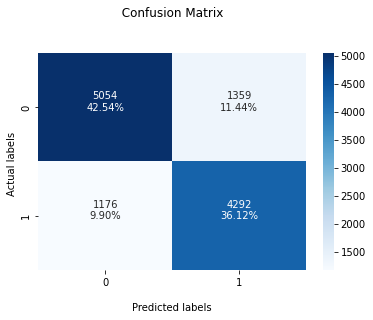

In [ ]:
plot_confusion_matrix(y_val_label_TS,y_pred_validation_LR_tfidf_TS_T1)

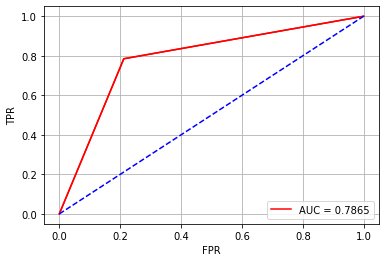

In [ ]:
plot_roc_curve(y_val_label_TS,y_pred_validation_LR_tfidf_TS_T1)

In [ ]:
y_predict_LR_tfidf_TS_T1=LR_tfidf_pipe.predict(x_test_text_TS_k)
y_predict_LR_tfidf_TS_T1

array([0, 0, 0, ..., 0, 0, 1])

In [ ]:
y_predict_pro_LR_tfidf_TS_T1=LR_tfidf_pipe.predict_proba(x_test_text_TS_k)
y_predict_pro_LR_tfidf_TS_T1[:,1]

array([0.44734164, 0.21519669, 0.44636205, ..., 0.14059602, 0.34720089,
       0.8014472 ])

In [ ]:
id=df_test_K['id']
pred_df = pd.DataFrame(data={'id': np.asarray(id), 'label': y_predict_pro_LR_tfidf_TS_T1[:,1]})

pred_df.to_csv('LR_tfidf_TS_T1.csv', index=False)

the test (kaggle) Score in this trial is 84%

####trial (Pipeline([("tfidf", TfidfVectorizer(ngram_range=(1,2),analyzer="word")), ('LogisticRegression', LogisticRegression())]))


In [ ]:
LR_tfidf_pipe_T2 = Pipeline([("tfidf", TfidfVectorizer(ngram_range=(1,2),analyzer="word")), ('LogisticRegression', LogisticRegression())])
#fit the model and print the score the model
LR_tfidf_pipe_T2.fit(x_train_text_TS, y_train_label_TS)  

Pipeline(steps=[('tfidf', TfidfVectorizer(ngram_range=(1, 2))),
                ('LogisticRegression', LogisticRegression())])

In [ ]:
LR_tfidf_pipe_T2.score(x_train_text_TS, y_train_label_TS)

0.9197213921972981

In [ ]:
y_pred_validation_LR_tfidf_TS_T2 = LR_tfidf_pipe_T2.predict(x_val_text_TS)

In [ ]:
y_pred_validation_LR_tfidf_TS_T2

array([1, 1, 1, ..., 1, 1, 1])

In [ ]:
#Accuracy
Accuracy=accuracy_score(y_val_label_TS,y_pred_validation_LR_tfidf_TS_T2) 
print("XGB_TS_T1_Accuracy:  " , (Accuracy))

XGB_TS_T1_Accuracy:   0.786634121706927


In [ ]:
print(classification_report(y_val_label_TS,y_pred_validation_LR_tfidf_TS_T2))

              precision    recall  f1-score   support

           0       0.81      0.79      0.80      6413
           1       0.76      0.78      0.77      5468

    accuracy                           0.79     11881
   macro avg       0.79      0.79      0.79     11881
weighted avg       0.79      0.79      0.79     11881



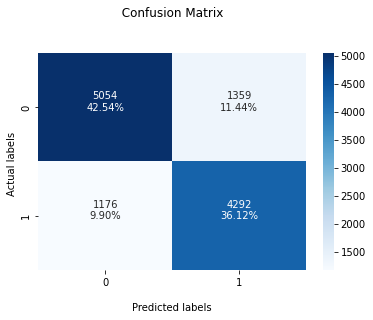

In [ ]:
plot_confusion_matrix(y_val_label_TS,y_pred_validation_LR_tfidf_TS_T2)

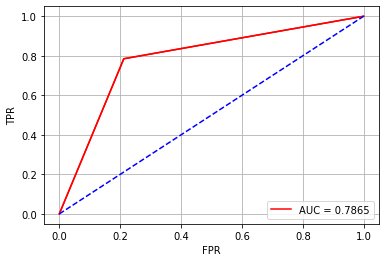

In [ ]:
plot_roc_curve(y_val_label_TS,y_pred_validation_LR_tfidf_TS_T2)

In [ ]:
y_predict_LR_tfidf_TS_T2=LR_tfidf_pipe_T2.predict(x_test_text_TS_k)
y_predict_LR_tfidf_TS_T2

array([0, 0, 0, ..., 0, 0, 1])

In [ ]:
y_predict_pro_LR_tfidf_TS_T2=LR_tfidf_pipe_T2.predict_proba(x_test_text_TS_k)
y_predict_pro_LR_tfidf_TS_T2

array([[0.55265836, 0.44734164],
       [0.78480331, 0.21519669],
       [0.55363795, 0.44636205],
       ...,
       [0.85940398, 0.14059602],
       [0.65279911, 0.34720089],
       [0.1985528 , 0.8014472 ]])

In [ ]:
id=df_test_K['id']
pred_df = pd.DataFrame(data={'id': np.asarray(id), 'label': y_predict_pro_LR_tfidf_TS_T2[:,1]})

pred_df.to_csv('LR_tfidf_TS_T2.csv', index=False)

the test (kaggle) Score in this trial is 84%

####trial (Hyperparamter search method (random) with ( cross-validation))

In [ ]:
# feature creation and modelling in a single function
LR_tfidf_pipe = Pipeline([("tfidf", TfidfVectorizer()), ("log", LogisticRegression())])

# define parameter space to test 
LR_tfidf_pipe_params = {
    "tfidf__ngram_range": [(1, 2), (1, 3)],
    "tfidf__analyzer":["word","char"],
    "tfidf__max_df": np.arange(0.3, 0.8),
    "tfidf__min_df": np.arange(5, 100),
    'log__penalty':['l1','l2'],
    'log__C':[1,1e2, 1e3,1e5],
    'log__max_iter':[100,1000,10000],

}

In [ ]:
#calculate running time
%%time
LR_tfidf_pipe_RS_TS = RandomizedSearchCV(LR_tfidf_pipe, LR_tfidf_pipe_params, cv=5, verbose=1, n_jobs=2, scoring="f1_macro")
LR_tfidf_pipe_RS_TS.fit(x_train_text_TS, y_train_label_TS)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
25 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  Fil

CPU times: user 14.9 s, sys: 1.13 s, total: 16 s
Wall time: 4min 46s


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                             ('log', LogisticRegression())]),
                   n_jobs=2,
                   param_distributions={'log__C': [1, 100.0, 1000.0, 100000.0],
                                        'log__max_iter': [100, 1000, 10000],
                                        'log__penalty': ['l1', 'l2'],
                                        'tfidf__analyzer': ['word', 'char'],
                                        'tfidf__max_df': array([0.3]),
                                        'tfidf__min_df': array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21,
       22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38,
       39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55,
       56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72,
       73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86

In [ ]:
print('best params {}'.format(LR_tfidf_pipe_RS_TS.best_params_))
print('best score {}'.format(LR_tfidf_pipe_RS_TS.best_score_))
print('best estimator {}'.format(LR_tfidf_pipe_RS_TS.best_estimator_))

best params {'tfidf__ngram_range': (1, 3), 'tfidf__min_df': 42, 'tfidf__max_df': 0.3, 'tfidf__analyzer': 'word', 'log__penalty': 'l2', 'log__max_iter': 1000, 'log__C': 100000.0}
best score 0.7635734379425865


In [ ]:
# run pipe with optimized parameters
LR_tfidf_pipe_RS_TS.best_estimator_.fit(x_train_text_TS, y_train_label_TS)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.3, min_df=42, ngram_range=(1, 3))),
                ('log', LogisticRegression(C=100000.0, max_iter=1000))])

In [ ]:
LR_tfidf_pipe_RS_TS.best_estimator_.score(x_train_text_TS, y_train_label_TS)

0.806510668742898

In [ ]:
y_pred_validation_LR_tfidf_pipe_RS_TS =LR_tfidf_pipe_RS_TS.best_estimator_.predict(x_val_text_TS)

In [ ]:
y_pred_validation_LR_tfidf_pipe_RS_TS

array([1, 1, 1, ..., 1, 1, 1])

In [ ]:
#Accuracy
Accuracy=accuracy_score(y_val_label_TS,y_pred_validation_LR_tfidf_pipe_RS_TS) 
print("XGB_tfidf_pipe_GS_Accuracy:  " , (Accuracy))

XGB_tfidf_pipe_GS_Accuracy:   0.7695480178436158


In [ ]:
print(classification_report(y_val_label_TS,y_pred_validation_LR_tfidf_pipe_RS_TS))

              precision    recall  f1-score   support

           0       0.79      0.78      0.78      6413
           1       0.75      0.76      0.75      5468

    accuracy                           0.77     11881
   macro avg       0.77      0.77      0.77     11881
weighted avg       0.77      0.77      0.77     11881



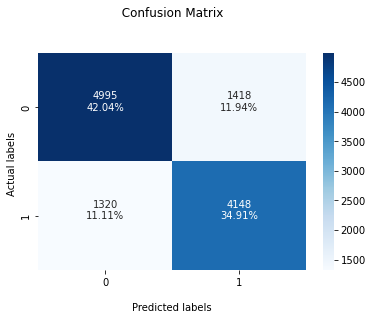

In [ ]:
plot_confusion_matrix(y_val_label_TS,y_pred_validation_LR_tfidf_pipe_RS_TS)

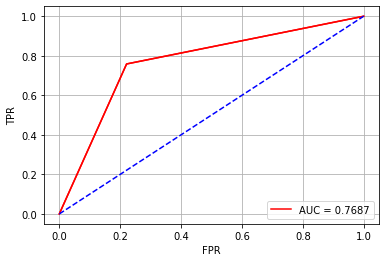

In [ ]:
plot_roc_curve(y_val_label_TS,y_pred_validation_LR_tfidf_pipe_RS_TS)

In [ ]:
y_predict_LR_tfidf_pipe_RS_TS=LR_tfidf_pipe_RS_TS.best_estimator_.predict(x_test_text_TS_k)
y_predict_LR_tfidf_pipe_RS_TS

array([0, 0, 1, ..., 0, 0, 1])

In [ ]:
y_predict_pro_LR_tfidf_pipe_RS_TS=LR_tfidf_pipe_RS_TS.best_estimator_.predict_proba(x_test_text_TS_k)
y_predict_pro_LR_tfidf_pipe_RS_TS

array([[5.97742506e-01, 4.02257494e-01],
       [9.41694228e-01, 5.83057715e-02],
       [2.50009174e-01, 7.49990826e-01],
       ...,
       [9.99998653e-01, 1.34666374e-06],
       [8.82771936e-01, 1.17228064e-01],
       [2.01241963e-01, 7.98758037e-01]])

In [ ]:
id=df_test_K['id']
pred_df = pd.DataFrame(data={'id': np.asarray(id), 'label': y_predict_pro_LR_tfidf_pipe_RS_TS[:,1]})

pred_df.to_csv('LR_tfidf_pipe_RS_TS.csv', index=False)

the test (kaggle) Score in this trial is 84%

####trial (Pipeline([("tfidf", TfidfVectorizer(ngram_range=(1,2),analyzer="word")), ('RandomForestClassifier', RandomForestClassifier())]))


In [ ]:
RF_tfidf_pipe = Pipeline([("tfidf", TfidfVectorizer(ngram_range=(1,2),analyzer="word")), ('RandomForestClassifier', RandomForestClassifier())])
#fit the model and print the score the model
RF_tfidf_pipe.fit(x_train_text_TS, y_train_label_TS)  

Pipeline(steps=[('tfidf', TfidfVectorizer(ngram_range=(1, 2))),
                ('RandomForestClassifier', RandomForestClassifier())])

In [ ]:
RF_tfidf_pipe.score(x_train_text_TS, y_train_label_TS)

0.9999789571145996

In [ ]:
y_pred_validation_RF_tfidf_TS_T1 = RF_tfidf_pipe.predict(x_val_text_TS)

In [ ]:
y_pred_validation_RF_tfidf_TS_T1

array([1, 0, 0, ..., 1, 1, 1])

In [ ]:
#Accuracy
Accuracy=accuracy_score(y_val_label_TS,y_pred_validation_RF_tfidf_TS_T1) 
print("RF_tfidf_TS_T1_Accuracy:  " , (Accuracy))

RF_tfidf_TS_T1_Accuracy:   0.7618887299048902


In [ ]:
print(classification_report(y_val_label_TS,y_pred_validation_RF_tfidf_TS_T1))

              precision    recall  f1-score   support

           0       0.78      0.78      0.78      6413
           1       0.74      0.74      0.74      5468

    accuracy                           0.76     11881
   macro avg       0.76      0.76      0.76     11881
weighted avg       0.76      0.76      0.76     11881



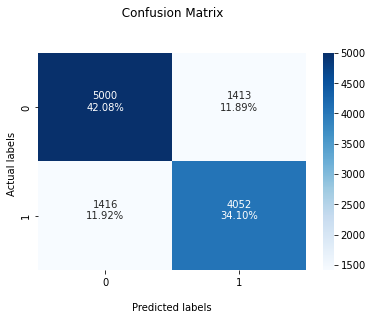

In [ ]:
plot_confusion_matrix(y_val_label_TS,y_pred_validation_RF_tfidf_TS_T1)

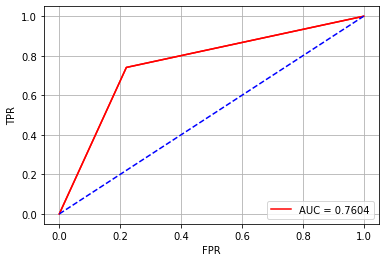

In [ ]:
plot_roc_curve(y_val_label_TS,y_pred_validation_RF_tfidf_TS_T1,)

In [ ]:
y_predict_RF_tfidf_TS_T1=RF_tfidf_pipe.predict(x_test_text_TS_k)
y_predict_RF_tfidf_TS_T1

array([0, 0, 1, ..., 0, 0, 1])

In [ ]:
y_predict_pro_RF_tfidf_TS_T1=RF_tfidf_pipe.predict_proba(x_test_text_TS_k)
y_predict_pro_RF_tfidf_TS_T1

array([[0.99, 0.01],
       [0.86, 0.14],
       [0.47, 0.53],
       ...,
       [0.73, 0.27],
       [0.83, 0.17],
       [0.29, 0.71]])

In [ ]:
id=df_test_K['id']
pred_df = pd.DataFrame(data={'id': np.asarray(id), 'label': y_predict_pro_RF_tfidf_TS_T1[:,1]})

pred_df.to_csv('RF_tfidf_TS_T1.csv', index=False)

the test (kaggle) Score in this trial is 87%

####trial (Pipeline([("tfidf", TfidfVectorizer(ngram_range=(1,3),analyzer="char")), ('RandomForestClassifier', RandomForestClassifier())]))


In [ ]:
RF_tfidf_pipe_T2 = Pipeline([("tfidf", TfidfVectorizer(ngram_range=(1,3),analyzer="char")), ('RandomForestClassifier', RandomForestClassifier())])
#fit the model and print the score the model
RF_tfidf_pipe_T2.fit(x_train_text_TS, y_train_label_TS)  

Pipeline(steps=[('tfidf', TfidfVectorizer(analyzer='char', ngram_range=(1, 3))),
                ('RandomForestClassifier', RandomForestClassifier())])

In [ ]:
RF_tfidf_pipe_T2.score(x_train_text_TS, y_train_label_TS)

0.9999789571145996

In [ ]:
y_pred_validation_RF_tfidf_TS_T2 = RF_tfidf_pipe_T2.predict(x_val_text_TS)

In [ ]:
y_pred_validation_RF_tfidf_TS_T2

array([1, 0, 0, ..., 1, 1, 1])

In [ ]:
#Accuracy
Accuracy=accuracy_score(y_val_label_TS,y_pred_validation_RF_tfidf_TS_T2) 
print("RF_tfidf_pipe_T2_Accuracy:  " , (Accuracy))

RF_tfidf_pipe_T2_Accuracy:   0.7048228263614174


In [ ]:
print(classification_report(y_val_label_TS,y_pred_validation_RF_tfidf_TS_T2))

              precision    recall  f1-score   support

           0       0.71      0.77      0.74      6413
           1       0.70      0.62      0.66      5468

    accuracy                           0.70     11881
   macro avg       0.70      0.70      0.70     11881
weighted avg       0.70      0.70      0.70     11881



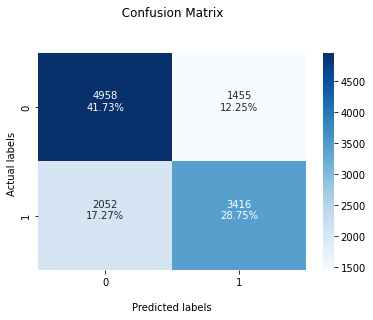

In [ ]:
plot_confusion_matrix(y_val_label_TS,y_pred_validation_RF_tfidf_TS_T2)

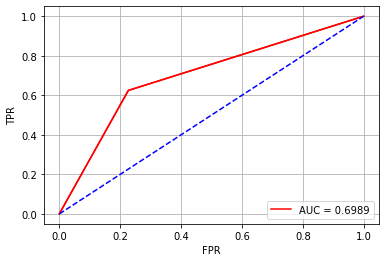

In [ ]:
plot_roc_curve(y_val_label_TS,y_pred_validation_RF_tfidf_TS_T2)

In [ ]:
y_predict_RF_tfidf_TS_T2=RF_tfidf_pipe_T2.predict(x_test_text_TS_k)
y_predict_RF_tfidf_TS_T2

array([0, 0, 1, ..., 0, 0, 1])

In [ ]:
y_predict_pro_RF_tfidf_TS_T2=RF_tfidf_pipe_T2.predict_proba(x_test_text_TS_k)
y_predict_pro_RF_tfidf_TS_T2

array([[0.82, 0.18],
       [0.85, 0.15],
       [0.45, 0.55],
       ...,
       [0.63, 0.37],
       [0.56, 0.44],
       [0.4 , 0.6 ]])

In [ ]:
id=df_test_K['id']
pred_df = pd.DataFrame(data={'id': np.asarray(id), 'label': y_predict_pro_RF_tfidf_TS_T2[:,1]})

pred_df.to_csv('RF_tfidf_TS_T2.csv', index=False)


the test (kaggle) Score in this trial is 86% 



####The highest score in this solution

apply ( Pipeline([("tfidf", TfidfVectorizer(ngram_range=(1,2),analyzer="word")), ('RandomForestClassifier', RandomForestClassifier())])
)

test (kaggle) score is 87%